In [1]:
# ------------------------------------------------------------------
# 0. Imports & settings
# ------------------------------------------------------------------
import re, warnings, numpy as np, pandas as pd, networkx as nx
from networkx.algorithms import bipartite
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

# ------------------------------------------------------------------
# 1. Load raw CSV files
# ------------------------------------------------------------------
all_candidates_state_bi   = pd.read_csv("all_candidates_state_bipartite_weighted_network.csv")
winning_candidates_state_bi = pd.read_csv("winning_candidates_state_bipartite_weighted_network.csv")
for df in (all_candidates_state_bi, winning_candidates_state_bi):
    df.index = df["Unnamed: 0"]
    df.drop(columns=["Unnamed: 0", "Unnamed: 1"], inplace=True)

federal_net = pd.read_csv("federal_contributor_top100_contributors_network.csv")
state_net   = pd.read_csv("state_contributor_top100_contributors_network.csv")
for df in (federal_net, state_net):
    df.index = df["Unnamed: 0"]
    df.drop(columns=["Unnamed: 0"], inplace=True)

train_raw = pd.read_csv("training_data.csv")
test_raw  = pd.read_csv("test_data.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'all_candidates_state_bipartite_weighted_network.csv'

In [799]:
# ------------------------------------------------------------------
# 2. Build projected state graphs
# ------------------------------------------------------------------
def build_projected_state_graph(df):
    B = nx.Graph()
    states, candidates = list(df.columns), list(df.index)
    B.add_nodes_from(candidates, bipartite=0)
    B.add_nodes_from(states,     bipartite=1)
    for s in states:
        for c in df[df[s] > 0].index:
            B.add_edge(s, c, weight=df.loc[c, s])

    def my_weight(G, u, v, w="weight"):
        return sum(G[u][nbr][w] + G[v][nbr][w] for nbr in set(G[u]) & set(G[v]))

    bottom_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 1}
    return bipartite.generic_weighted_projected_graph(B, bottom_nodes, weight_function=my_weight)

G_all, G_win = (build_projected_state_graph(all_candidates_state_bi),
                build_projected_state_graph(winning_candidates_state_bi))

# ------------------------------------------------------------------
# 3. Parse top‑100 column metadata
# ------------------------------------------------------------------
def parse_meta(df_net):
    meta = {}
    for col in df_net.columns:
        name = " ".join(col.split(" ")[:-2])
        meta[col] = {
            "name": name,
            "contributor_type": "Non-Individual" if re.search(",", name) is None else "Individual",
            "zip_code": str(col.split(" ")[-2] or "0"),
            "state": col.split(" ")[-1],
        }
    return meta

federal_meta, state_meta = parse_meta(federal_net), parse_meta(state_net)

In [800]:
# ------------------------------------------------------------------
# 4. Build all_data base frame
# ------------------------------------------------------------------
train_raw["train_label"], test_raw["train_label"] = 1, 0
train_raw["index"], test_raw["index"] = train_raw.index, test_raw.index
all_data = pd.concat([train_raw, test_raw], ignore_index=True)

if "zip_code" in all_data.columns:
    all_data["zip_code"] = all_data["zip_code"].astype(str)


# ------------------------------------------------------------------
# 5. Add centrality & communities
# ------------------------------------------------------------------
def add_degree(df, G, col, w=None):
    return df.merge(pd.DataFrame(nx.degree(G, weight=w), columns=["state", col]), how="left")

all_data = (all_data
            .pipe(add_degree, G_all, "d_all")
            .pipe(add_degree, G_win, "d_win")
            .pipe(add_degree, G_all, "d_weight_all", "weight")
            .pipe(add_degree, G_win, "d_weight_win", "weight"))

def add_partition(df, G, label, alg):
    groups = alg(G)
    lbl, num = np.full(len(df), -1, int), np.full(len(df), -1, int)
    for cid, nodes in enumerate(groups):
        m = df["state"].isin(nodes)
        lbl[m], num[m] = cid, len(nodes)
    df[f"{label}"], df[f"{label}_num"] = lbl, num
    return df

all_data = add_partition(all_data, G_all, "greedy_modularity",
                         lambda g: nx.community.greedy_modularity_communities(g, weight="weight"))
all_data = add_partition(all_data, G_win, "greedy_modularity_win",
                         lambda g: nx.community.greedy_modularity_communities(g, weight="weight"))
all_data = add_partition(all_data, G_all, "louvain_communities",
                         nx.community.louvain_communities)
all_data = add_partition(all_data, G_win, "louvain_communities_win",
                         nx.community.louvain_communities)   
# ------------------------------------------------------------------
# 6. Contributor summaries with UNIQUE metric names
# ------------------------------------------------------------------
def contributor_features(net, meta, tag):
    """
    Returns four frames with unique metric columns:
      mean_deg_<tag>_by_state
      mean_deg_<tag>_by_type
      mean_deg_<tag>_by_zip
      mean_deg_<tag>_by_stz
    """
    d = pd.DataFrame(nx.degree(nx.from_pandas_adjacency(net), weight="weight"),
                     columns=["name", "deg"])
    ann = d["name"].apply(lambda n: meta.get(n, {})).apply(pd.Series)
    d = pd.concat([d, ann[["state", "contributor_type", "zip_code"]]], axis=1)
    d["zip_code"] = d["zip_code"].astype(str)

    s = d.groupby("state")["deg"].mean().reset_index()\
         .rename(columns={"deg": f"mean_deg_{tag}_by_state"})
    t = d.groupby("contributor_type")["deg"].mean().reset_index()\
         .rename(columns={"deg": f"mean_deg_{tag}_by_type"})
    z = d.groupby("zip_code")["deg"].mean().reset_index()\
         .rename(columns={"deg": f"mean_deg_{tag}_by_zip"})
    stz = (d.groupby(["state", "contributor_type", "zip_code"])["deg"]
             .mean().reset_index()
             .rename(columns={"deg": f"mean_deg_{tag}_by_stz"}))
    return s, t, z, stz

s_state, s_type, s_zip, s_stz = contributor_features(state_net,   state_meta,   "state")
f_state, f_type, f_zip, f_stz = contributor_features(federal_net, federal_meta, "federal")


# ------------------------------------------------------------------
# 6‑B. Merge without duplicate names
# ------------------------------------------------------------------
for df_sub, keys in [
    (s_state, ["state"]), (f_state, ["state"]),
    (s_type,  ["contributor_type"]), (f_type,  ["contributor_type"]),
    (s_zip,   ["zip_code"]), (f_zip,   ["zip_code"]),
    (s_stz,   ["state", "contributor_type", "zip_code"]),
    (f_stz,   ["state", "contributor_type", "zip_code"]),
]:
    all_data = all_data.merge(df_sub, how="left", on=keys)

# Treat data ambiguity

In [801]:

# replace the '#NAME?' strings that slipped through
all_data.replace("#NAME?", 0, inplace=True)

# Remove duplicate records

In [802]:
# 1. Check how many duplicate rows exist
num_duplicates_all_data = all_data.duplicated().sum()

print(f"🔍 Number of duplicate rows in all_data: {num_duplicates_all_data}")

# 2. Drop duplicate records
all_data = all_data.drop_duplicates()

print(f"✅ Duplicates removed for train. New shape: {all_data.shape}")


🔍 Number of duplicate rows in all_data: 0
✅ Duplicates removed for train. New shape: (288080, 63)


## Treat missing values in categorical data

In [803]:

cat_vars = ['general_sector', 'city', 'zip_code', 'specific_sector', 'state',
       'contributor_type']

In [804]:
train_df = all_data[all_data["train_label"] == 1].drop(columns=["index"])
test_df  = all_data[all_data["train_label"] == 0]

In [805]:
import numpy as np
import pandas as pd

# 0) start from your original all_data
df = all_data.copy()

# 1) define your train/test mask
train_mask = df["train_label"] == 1 
test_mask  = df["train_label"] == 0

# 2) pull out train/test slices
train_df = df.loc[train_mask, cat_vars].copy()
test_df  = df.loc[test_mask,  cat_vars].copy()

# 3) define your fake‐missing tokens
fake_missing = ['0', '0.0', 'None', '', 'nan', 'NaN']

# 4) clean + impute each slice
for col in cat_vars:
    # lowercase & strip before mapping
    train_col = train_df[col].astype(str).str.strip().str.lower()
    test_col  = test_df[col].astype(str).str.strip().str.lower()

    # map fake_missing → real NaN
    train_col = train_col.replace(fake_missing, np.nan)
    test_col  = test_col.replace (fake_missing, np.nan)

    # find the mode on the cleaned train_col
    if train_col.dropna().empty:
        mode_val = np.nan
    else:
        mode_val = train_col.dropna().mode().iloc[0]

    # fill both train+test
    train_df[col] = train_col.fillna(mode_val)
    test_df[col]  = test_col. fillna(mode_val)

    print(f"Filled '{col}': mode = {mode_val!r}")

# 5) now re-assemble into one DataFrame, preserving all other columns verbatim
all_data = df.copy()
all_data.loc[train_mask, cat_vars] = train_df
all_data.loc[test_mask,  cat_vars] = test_df

# that's it—`all_data_filled` has your imputed categoricals in place
# you can now continue modeling off `all_data_filled` instead of `all_data`.


Filled 'general_sector': mode = 'uncoded'
Filled 'city': mode = 'washington'
Filled 'zip_code': mode = '20016.0'
Filled 'specific_sector': mode = 'uncoded'
Filled 'state': mode = 'us'
Filled 'contributor_type': mode = 'individual'


In [806]:
train_df = all_data[all_data["train_label"] == 1].drop(columns=["index"])
test_df  = all_data[all_data["train_label"] == 0]

# Check association between categorical variables and target variable

In [807]:
from scipy.stats import mannwhitneyu, kruskal, shapiro
import pandas as pd

cat_vars = ['general_sector', 'city', 'zip_code', 'specific_sector', 'state', 'contributor_type']

# Ensure winner_ratio is numeric
train_df = all_data[all_data["train_label"] == 1].drop(columns=["index"])
train_df["winner_ratio"] = pd.to_numeric(train_df["winner_ratio"], errors="coerce")

# Shapiro test to confirm non-normality
stat, pval = shapiro(train_df["winner_ratio"].dropna())
print(f"\n📈 Normality (Shapiro-Wilk): W = {stat:.4f}, p = {pval:.4f} → {'Normal' if pval > 0.05 else 'Not Normal'}")

import pandas as pd
import numpy as np
from scipy.stats import kruskal
import pandas as pd
import numpy as np
from scipy.stats import kruskal
from scipy.stats import shapiro

def test_categorical_vs_target(df, cat_vars, target_col="winner_ratio"):
    
    results = []
    print("🧪 Testing association between categorical vars and target...\n")

    for col in cat_vars:
        if col not in df.columns:
            print(f"🚫 Column missing: {col}")
            continue

        n_unique = df[col].nunique(dropna=True)
        print(f"\n📊 Analyzing '{col}' — {n_unique} unique categories")

        if n_unique < 2:
            print(f"⚠️ Skipping '{col}' — only one valid category")
            continue

        # Drop missing
        data = df[[col, target_col]].dropna()

        # Group winner_ratio by category
        try:
            group_list = [grp[target_col].values for _, grp in data.groupby(col)]
        except Exception as e:
            print(f"❌ Error grouping by '{col}': {e}")
            continue

        if len(group_list) < 2:
            print(f"⚠️ Skipping '{col}' — not enough groups after dropna")
            continue

        try:
            stat, pval = kruskal(*group_list)
        except Exception as e:
            print(f"❌ Kruskal test failed for '{col}': {e}")
            continue

        print(f"✅ Kruskal–Wallis H → stat = {stat:.2f}, p = {pval:.2e}")
        results.append({
            "column": col,
            "n_categories": n_unique,
            "test": "Kruskal–Wallis H",
            "stat": stat,
            "p_value": pval
        })

    results_df = pd.DataFrame(results).sort_values("p_value")
    print("\n📈 Summary of most associated categorical features:")
    print(results_df.head(10))
    
    return results_df


# Your variables
cat_vars = ['general_sector', 'city', 'zip_code', 'specific_sector', 'state', 'contributor_type']
# Call the function
results_df = test_categorical_vs_target(train_df, cat_vars, target_col="winner_ratio")
# Top 5
results_df.head(6)


/localdisk4/panwla/conda_envs/env3.10/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 172848.
  res = hypotest_fun_out(*samples, **kwds)



📈 Normality (Shapiro-Wilk): W = 0.7948, p = 0.0000 → Not Normal
🧪 Testing association between categorical vars and target...


📊 Analyzing 'general_sector' — 135 unique categories
✅ Kruskal–Wallis H → stat = 2276.99, p = 0.00e+00

📊 Analyzing 'city' — 8758 unique categories
✅ Kruskal–Wallis H → stat = 14708.76, p = 4.66e-309

📊 Analyzing 'zip_code' — 15459 unique categories
✅ Kruskal–Wallis H → stat = 22708.24, p = 3.90e-286

📊 Analyzing 'specific_sector' — 408 unique categories
✅ Kruskal–Wallis H → stat = 3024.15, p = 0.00e+00

📊 Analyzing 'state' — 46 unique categories
✅ Kruskal–Wallis H → stat = 4025.73, p = 0.00e+00

📊 Analyzing 'contributor_type' — 3 unique categories
✅ Kruskal–Wallis H → stat = 1895.65, p = 0.00e+00

📈 Summary of most associated categorical features:
             column  n_categories              test          stat  \
0    general_sector           135  Kruskal–Wallis H   2276.987520   
3   specific_sector           408  Kruskal–Wallis H   3024.146795   
5  contr

,column,n_categories,test,stat,p_value
0,general_sector,135,Kruskal–Wallis H,2276.987520,0.000000e+00
3,specific_sector,408,Kruskal–Wallis H,3024.146795,0.000000e+00
5,contributor_type,3,Kruskal–Wallis H,1895.649969,0.000000e+00
4,state,46,Kruskal–Wallis H,4025.727373,0.000000e+00
1,city,8758,Kruskal–Wallis H,14708.756860,4.661116e-309
2,zip_code,15459,Kruskal–Wallis H,22708.244731,3.904215e-286


### Notes: city and zip_code found to be not useful

### Dropping zip_code and city columns, since they're found to be least significant and with high cardinallity

In [808]:
cols_to_drop = ["city", "zip_code", 
                "specific_sector"
                ]
for col in cols_to_drop:
    cat_vars.remove(col)

all_data.drop(cols_to_drop, axis=1, inplace= True)

## Bucketize different general sector categories into bigger category

In [809]:
import yaml

# 1) Normalization helper
def _norm(s):
    """Lowercase, strip whitespace for consistent matching."""
    return str(s).strip().lower()

# 2) Load your umbrella map from YAML
with open("./sector_mapping.yaml", "r") as f:
    umbrella_map = yaml.safe_load(f)

# 3) Build a normalized flat_map: raw_label → umbrella_category
flat_map = {
    _norm(raw): umbrella
    for umbrella, raws in umbrella_map.items()
    for raw in raws
}

# 4) Identify anything in your data not yet covered
all_normed = set(all_data["general_sector"].apply(_norm).unique())
covered   = set(flat_map.keys())
unmapped  = all_normed - covered

print("❗ Categories not covered in YAML map:", unmapped)
print(f"Total uncovered = {len(unmapped)}")

# 5) Map into a new column, defaulting to "Other / Misc"
all_data["general_sector_new"] = (
    all_data["general_sector"]
        .apply(_norm)
        .map(flat_map)
        .fillna("Other / Misc")
)

# 6) Inspect results
n_uniques = all_data["general_sector_new"].nunique()
print("new unique categories in general_sector_new:", n_uniques)

vc = all_data["general_sector_new"].value_counts(dropna=False)
print("\nValue counts:\n", vc)

❗ Categories not covered in YAML map: set()
Total uncovered = 0
new unique categories in general_sector_new: 17

Value counts:
 general_sector_new
Unknown / Uncoded                 88827
Legal & Lobbying                  51060
Retired / Homemakers              40111
Finance & Real Estate             26396
Health & Pharma                   18138
Public Sector & Campaigns         13481
Construction & Manufacturing      12408
Retail, Food & Hospitality         9047
Education & Nonprofit              8769
Labor & Trade                      5053
Energy & Resources                 3839
Technology & Telecom               3326
Transportation & Logistics         2394
Entertainment & Media              2242
Policy & Single-Issue              1031
Agriculture & Natural Products     1001
Defense & Military                  957
Name: count, dtype: int64


In [810]:
train_df = all_data[all_data["train_label"] == 1].drop(columns=["index"])
test_df  = all_data[all_data["train_label"] == 0]

In [811]:
new_cat_vars = ['general_sector_new', 'city', 'zip_code', 'specific_sector', 'state', 'contributor_type']

results_df = test_categorical_vs_target(train_df, new_cat_vars, target_col="winner_ratio")
# Top 5
results_df.head(7)

🧪 Testing association between categorical vars and target...


📊 Analyzing 'general_sector_new' — 17 unique categories
✅ Kruskal–Wallis H → stat = 1353.98, p = 1.27e-278
🚫 Column missing: city
🚫 Column missing: zip_code
🚫 Column missing: specific_sector

📊 Analyzing 'state' — 46 unique categories
✅ Kruskal–Wallis H → stat = 4025.73, p = 0.00e+00

📊 Analyzing 'contributor_type' — 3 unique categories
✅ Kruskal–Wallis H → stat = 1895.65, p = 0.00e+00

📈 Summary of most associated categorical features:
               column  n_categories              test         stat  \
1               state            46  Kruskal–Wallis H  4025.727373   
2    contributor_type             3  Kruskal–Wallis H  1895.649969   
0  general_sector_new            17  Kruskal–Wallis H  1353.983415   

         p_value  
1   0.000000e+00  
2   0.000000e+00  
0  1.265894e-278  


,column,n_categories,test,stat,p_value
1,state,46,Kruskal–Wallis H,4025.727373,0.000000e+00
2,contributor_type,3,Kruskal–Wallis H,1895.649969,0.000000e+00
0,general_sector_new,17,Kruskal–Wallis H,1353.983415,1.265894e-278


### Note: keep only general_sector_new, state, and contributor_type. Keep specific_sector only if using NN with embedding layers

## Drop specific sector column, since we already have bigger categories for sector 

In [812]:

all_data.drop(["general_sector"], axis=1, inplace=True)

cat_vars = ['general_sector_new', 
            # "specific_sector",
            'state', 'contributor_type']


In [813]:
# Identify money, count and ratio cols
ratio_cols = [col for col in all_data.columns if col.endswith('_ratio') and col != 'winner_ratio']
count_cols = [col for col in all_data.columns if col.endswith('_count')]
money_cols = [col for col in all_data.columns if col.endswith('_usd')]
# ratio_cols, count_cols, money_cols

# Treat non-infinite values and negative values in money columns

In [814]:
import numpy as np
import pandas as pd

def check_non_finite_vals(df, cols):
    cols_to_check = []
    for col in cols:
        # Convert to numeric (coerce errors to NaN)
        numeric_col = pd.to_numeric(df[col], errors='coerce')
        if not np.all(np.isfinite(numeric_col)):
            cols_to_check.append(col)
            print(f"{col} has non-finite values.")
    return cols_to_check


def check_neg_vals(df, cols):
    cols_to_check = []
    for col in cols:
        # Convert column to numeric, coercing errors to NaN
        numeric_col = pd.to_numeric(df[col], errors='coerce')
        has_negative = (numeric_col < 0).any()
        if has_negative:
            cols_to_check.append(col)
            print(f"{col} has negative values")
    return cols_to_check


print("\n\n", "#" * 10, "Checking cols for non-finite values", "#" * 10)

check_non_finite_vals(all_data, money_cols)

print("\n\n", "#" * 10, "Checking cols for negative values", "#" * 10)

check_neg_vals(all_data, money_cols)




 ########## Checking cols for non-finite values ##########


 ########## Checking cols for negative values ##########
contribution_democratic_sum_2010_usd has negative values
contribution_republican_sum_2010_usd has negative values
contribution_sum_2010_usd has negative values
governor_contributions_sum_2010_usd has negative values
house_and_assembly_contributions_sum_2010_usd has negative values
senate_contributions_sum_2010_usd has negative values
us_house_contributions_sum_2010_usd has negative values
us_senate_contributions_sum_2010_usd has negative values


['contribution_democratic_sum_2010_usd',
 'contribution_republican_sum_2010_usd',
 'contribution_sum_2010_usd',
 'governor_contributions_sum_2010_usd',
 'house_and_assembly_contributions_sum_2010_usd',
 'senate_contributions_sum_2010_usd',
 'us_house_contributions_sum_2010_usd',
 'us_senate_contributions_sum_2010_usd']

In [815]:
### Make total contribution to be positive

def makecontribution_positive(df, cols):
    for col in cols:
        if (df[col] < 0).any():
           df[col] = df[col].abs()
    return df



makecontribution_positive(all_data, money_cols)

all_data[money_cols].describe()

,contribution_democratic_sum_2010_usd,contribution_republican_sum_2010_usd,contribution_sum_2010_usd,governor_contributions_sum_2010_usd,house_and_assembly_contributions_sum_2010_usd,senate_contributions_sum_2010_usd,us_house_contributions_sum_2010_usd,us_senate_contributions_sum_2010_usd
count,2.880800e+05,2.880800e+05,2.880800e+05,2.880800e+05,2.880800e+05,2.880800e+05,2.880800e+05,2.880800e+05
mean,5.733310e+03,6.107083e+03,1.183925e+04,1.727034e+03,1.516238e+03,1.167192e+03,3.888976e+03,2.893454e+03
std,6.553043e+05,6.566684e+05,1.262429e+06,1.758889e+05,6.863660e+04,4.353378e+04,6.376477e+05,6.215562e+05
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,3.030600e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.275400e+02,3.501000e+01,9.978450e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.266300e+03,1.000000e+03,2.780440e+03,2.963400e+02,2.694275e+02,1.000000e+02,0.000000e+00,0.000000e+00
max,3.395247e+08,3.099551e+08,6.494798e+08,7.616125e+07,2.229992e+07,1.375416e+07,3.405236e+08,3.089563e+08



#### Fix ratio columns related to contribution_sum_2010_usd -
- house_and_assembly_contribution_ratio = house_and_assembly_contributions_sum_2010_usd / contribution_sum_2010_usd
- senate_contribution_ratio = senate_contributions_sum_2010_usd / contribution_sum_2010_usd
- us_house_contribution_ratio = us_house_contributions_sum_2010_usd / contribution_sum_2010_usd
- us_senate_contribution_ratio = us_senate_contributions_sum_2010_usd / contribution_sum_2010_usd
- governor_contribution_ratio = governor_contributions_sum_2010_usd / contribution_sum_2010_usd

In [816]:
# # Create ration for democratic and republican contributions

numerator_cols, denominator_col = ["contribution_democratic_sum_2010_usd","contribution_republican_sum_2010_usd"], "contribution_sum_2010_usd"

def parties_contri_ratios(df, numerator_cols, denominator_col, fill_value=0):
    """
    Compute ratio columns safely and name them dynamically from numerator column prefixes.
    """
    for num_col in numerator_cols:
        prefix = "_".join(num_col.split("_")[:2])  # get first two parts for clarity
        ratio_col = f"{prefix}_ratio"
        df[ratio_col] = np.where(
            df[denominator_col] == 0,
            fill_value,
            df[num_col] / df[denominator_col]
        )
    return df

all_data = parties_contri_ratios(all_data, numerator_cols, denominator_col, fill_value=0)

In [817]:
all_data.loc[:, numerator_cols].head()

,contribution_democratic_sum_2010_usd,contribution_republican_sum_2010_usd
0,350.00,0.0
1,154.67,0.0
2,354.44,0.0
3,250.00,0.0
4,146.06,0.0


In [818]:
import numpy as np

_ratio_specs = {
    "governor_contribution_ratio":           ("governor_contributions_sum_2010_usd",       "contribution_sum_2010_usd"),
    "house_and_assembly_contribution_ratio": ("house_and_assembly_contributions_sum_2010_usd","contribution_sum_2010_usd"),
    "senate_contribution_ratio":             ("senate_contributions_sum_2010_usd",          "contribution_sum_2010_usd"),
    "us_house_contribution_ratio":           ("us_house_contributions_sum_2010_usd",        "contribution_sum_2010_usd"),
    "us_senate_contribution_ratio":          ("us_senate_contributions_sum_2010_usd",       "contribution_sum_2010_usd"),
}

def fix_ratios(df, name=""):
    for r, (num, den) in _ratio_specs.items():
        raw = df[num] / df[den].replace(0, np.nan)
        affected = raw.isna().sum()
        print(f"[{name}] {r}: {affected} rows have been fixed")
        clipped = raw.clip(0, 1)
        df[r] = clipped.fillna(clipped.median())
    return df

all_data = fix_ratios(all_data, "train")

[train] governor_contribution_ratio: 299 rows have been fixed
[train] house_and_assembly_contribution_ratio: 299 rows have been fixed
[train] senate_contribution_ratio: 299 rows have been fixed
[train] us_house_contribution_ratio: 299 rows have been fixed
[train] us_senate_contribution_ratio: 299 rows have been fixed


In [819]:
all_data.loc[:, money_cols].describe()

,contribution_democratic_sum_2010_usd,contribution_republican_sum_2010_usd,contribution_sum_2010_usd,governor_contributions_sum_2010_usd,house_and_assembly_contributions_sum_2010_usd,senate_contributions_sum_2010_usd,us_house_contributions_sum_2010_usd,us_senate_contributions_sum_2010_usd
count,2.880800e+05,2.880800e+05,2.880800e+05,2.880800e+05,2.880800e+05,2.880800e+05,2.880800e+05,2.880800e+05
mean,5.733310e+03,6.107083e+03,1.183925e+04,1.727034e+03,1.516238e+03,1.167192e+03,3.888976e+03,2.893454e+03
std,6.553043e+05,6.566684e+05,1.262429e+06,1.758889e+05,6.863660e+04,4.353378e+04,6.376477e+05,6.215562e+05
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,3.030600e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.275400e+02,3.501000e+01,9.978450e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.266300e+03,1.000000e+03,2.780440e+03,2.963400e+02,2.694275e+02,1.000000e+02,0.000000e+00,0.000000e+00
max,3.395247e+08,3.099551e+08,6.494798e+08,7.616125e+07,2.229992e+07,1.375416e+07,3.405236e+08,3.089563e+08


In [820]:
all_data[money_cols].describe().to_csv("money_df.csv")

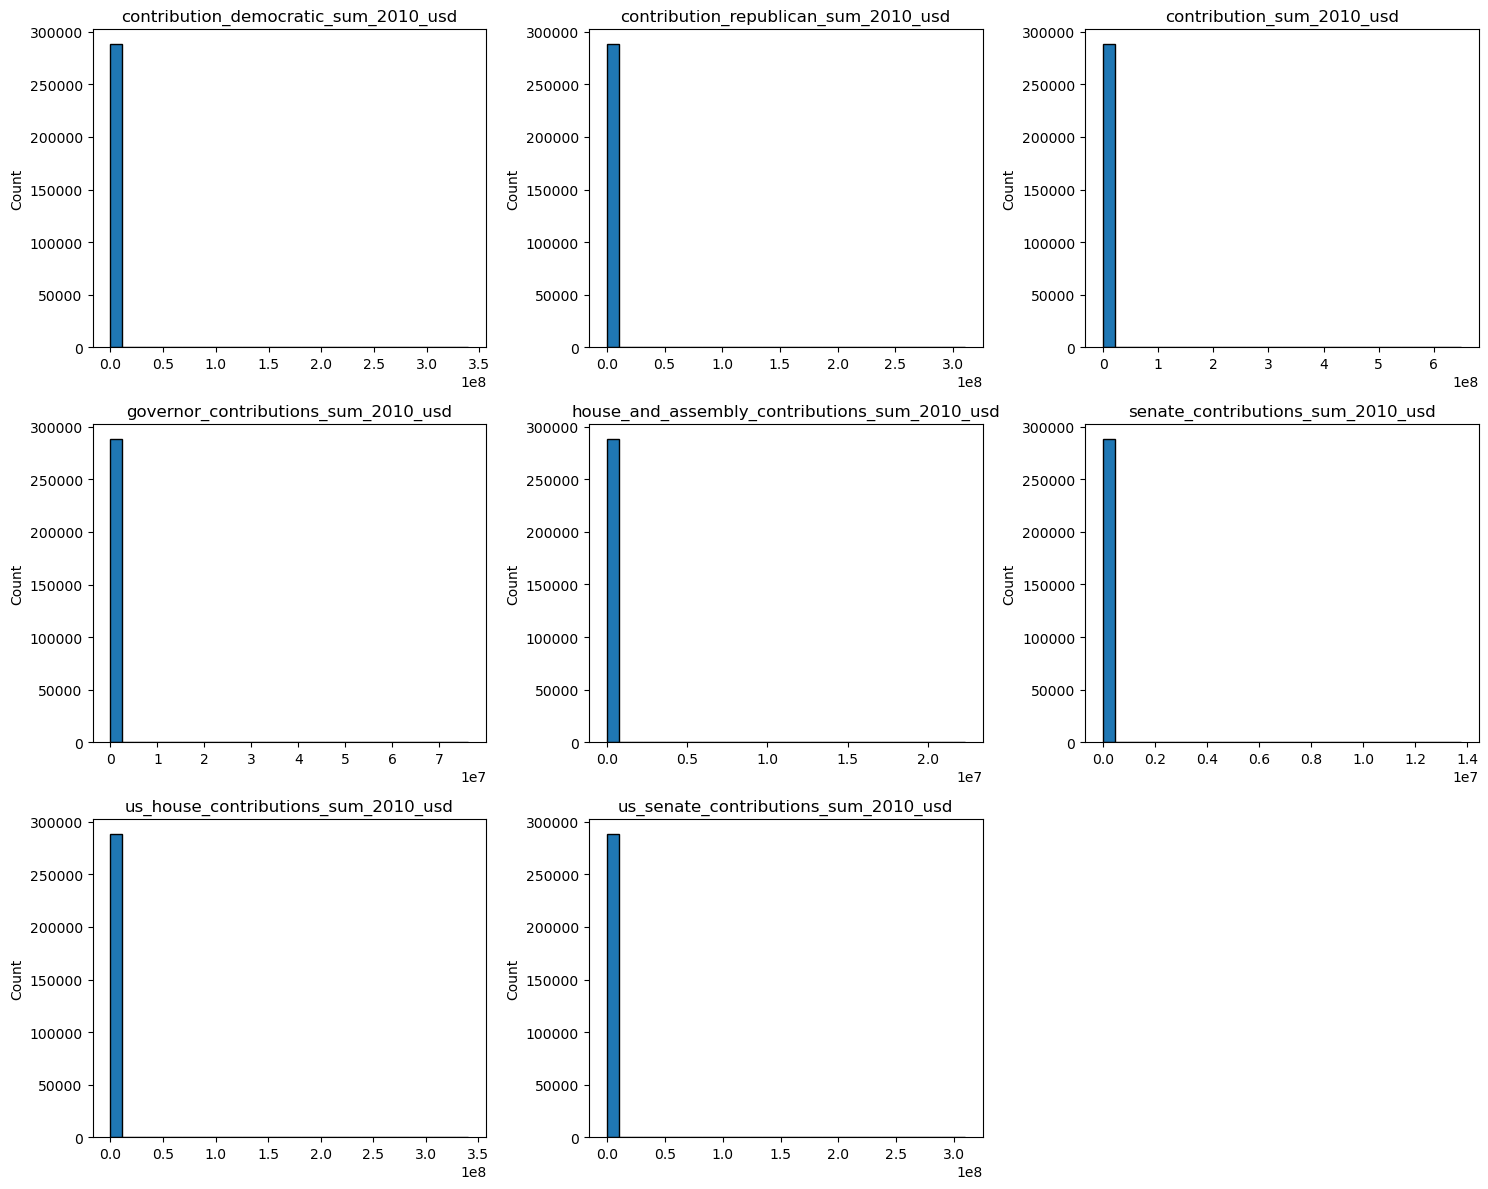

In [821]:
import matplotlib.pyplot as plt

def plot_histograms(df, train_num_vars, bins=30, cols=3, figsize=(15, 4)):
    n = len(train_num_vars)
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(figsize[0], figsize[1] * rows))
    axes = axes.flatten()
    
    for ax, col in zip(axes, train_num_vars):
        ax.hist(df[col].dropna(), bins=bins, edgecolor='black')
        ax.set_title(col)
        ax.set_xlabel('')
        ax.set_ylabel('Count')
    
    # remove any unused subplots
    for ax in axes[n:]:
        fig.delaxes(ax)
    
    plt.tight_layout()
    plt.show()
    
plot_histograms(all_data, money_cols)


### Implement pipeline to take log transformation of money related columns and then standardize them, and then normalize count related columns

In [822]:
# Identify money, count and ratio cols
ratio_cols = [col for col in all_data.columns if col.endswith('_ratio') and col != 'winner_ratio']
count_cols = [col for col in all_data.columns if col.endswith('_count')]
money_cols = [col for col in all_data.columns if col.endswith('_usd')]

In [823]:
all_data[ratio_cols].describe()

,candidacy_democratic_ratio,candidacy_republican_ratio,contribution_democratic_count_ratio,contribution_republican_count_ratio,governor_contribution_ratio,house_and_assembly_contribution_ratio,politician_challenger_ratio,politician_democratic_ratio,politician_incumbency_ratio,politician_open_pos_ratio,politician_republican_ratio,senate_contribution_ratio,us_house_contribution_ratio,us_senate_contribution_ratio,contribution_democratic_ratio,contribution_republican_ratio
count,288080.000000,288080.000000,288080.000000,288080.000000,288080.000000,288080.000000,288080.000000,288080.00000,288080.000000,288080.000000,288080.00000,288080.000000,288080.000000,288080.00000,288080.000000,288080.000000
mean,0.555539,0.444461,0.555777,0.444223,0.258245,0.257757,0.160335,0.55569,0.390602,0.424763,0.44431,0.164037,0.115924,0.08387,0.556828,0.445738
std,0.468435,0.468435,0.469598,0.469598,0.396861,0.391754,0.305163,0.46788,0.408525,0.413818,0.46788,0.324390,0.290975,0.24282,0.577046,0.575515
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.818182,0.181818,0.846154,0.153846,0.000000,0.000000,0.000000,0.80000,0.333333,0.333333,0.20000,0.000000,0.000000,0.00000,0.898489,0.095554
75%,1.000000,1.000000,1.000000,1.000000,0.519614,0.492714,0.200000,1.00000,0.800000,1.000000,1.00000,0.121227,0.000000,0.00000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.00000,1.000000,1.000000,1.00000,123.951220,122.951220


In [824]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
import numpy as np

# Preserve column names through identity transform
identity = FunctionTransformer(validate=True, feature_names_out="one-to-one")

# Count columns: just MinMax scaling
count_pipeline = Pipeline([
    ("identity", identity),  # preserves names
    ("scale", MinMaxScaler())
])

# Money columns: log1p + StandardScaler
money_pipeline = Pipeline([
    ("log",   FunctionTransformer(np.log1p, inverse_func=np.expm1, validate=True, feature_names_out="one-to-one")),
    ("scale", StandardScaler())
])

# Main transformation pipeline
dataset_transformation = ColumnTransformer(
    transformers=[
        ("label", "passthrough",  ["winner_ratio"]),
        ("count", count_pipeline, ["candidacy_count",
                                   "contribution_count", 
                                   "politician_count"]),
        ("money", money_pipeline, ["contribution_sum_2010_usd"]),
        ("ratio", "passthrough",  ["candidacy_democratic_ratio",
                                   "contribution_democratic_count_ratio",
                                   "politician_democratic_ratio",
                                   "politician_open_pos_ratio",
                                   "politician_incumbency_ratio",
                                   "politician_challenger_ratio",
                                   "contribution_democratic_ratio",
                                   "contribution_republican_ratio",
                                   "senate_contribution_ratio",
                                   "governor_contribution_ratio",
                                   "house_and_assembly_contribution_ratio",
                                   "us_house_contribution_ratio",
                                   "us_senate_contribution_ratio"])
    ],
    verbose_feature_names_out=True
).set_output(transform="pandas")

# Transform your data
transformed_data = dataset_transformation.fit_transform(all_data)
# Strip prefixes for cleaner column names (optional)
transformed_data.columns = [col.split("__")[-1] for col in transformed_data.columns]

# Optional: view or inspect transformed data
print(transformed_data.head())


   winner_ratio  candidacy_count  contribution_count  politician_count  \
0           1.0         0.000398            0.000122          0.000568   
1           0.5         0.000000            0.000000          0.000000   
2           1.0         0.000398            0.000061          0.000568   
3           1.0         0.000398            0.000061          0.000568   
4           0.0         0.000398            0.000122          0.000568   

   contribution_sum_2010_usd  candidacy_democratic_ratio  \
0                  -0.577766                         1.0   
1                  -1.041489                         1.0   
2                  -0.570597                         1.0   
3                  -0.769024                         1.0   
4                  -1.073940                         1.0   

   contribution_democratic_count_ratio  politician_democratic_ratio  \
0                                  1.0                          1.0   
1                                  1.0              

/localdisk4/panwla/conda_envs/env3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(


In [825]:
# Identify money, count and ratio cols
ratio_cols = [col for col in all_data.columns if col.endswith('_ratio') and col != 'winner_ratio']
count_cols = [col for col in all_data.columns if col.endswith('_count')]
money_cols = [col for col in all_data.columns if col.endswith('_usd')]

In [ ]:
plot_histograms(all_data, ratio_cols)

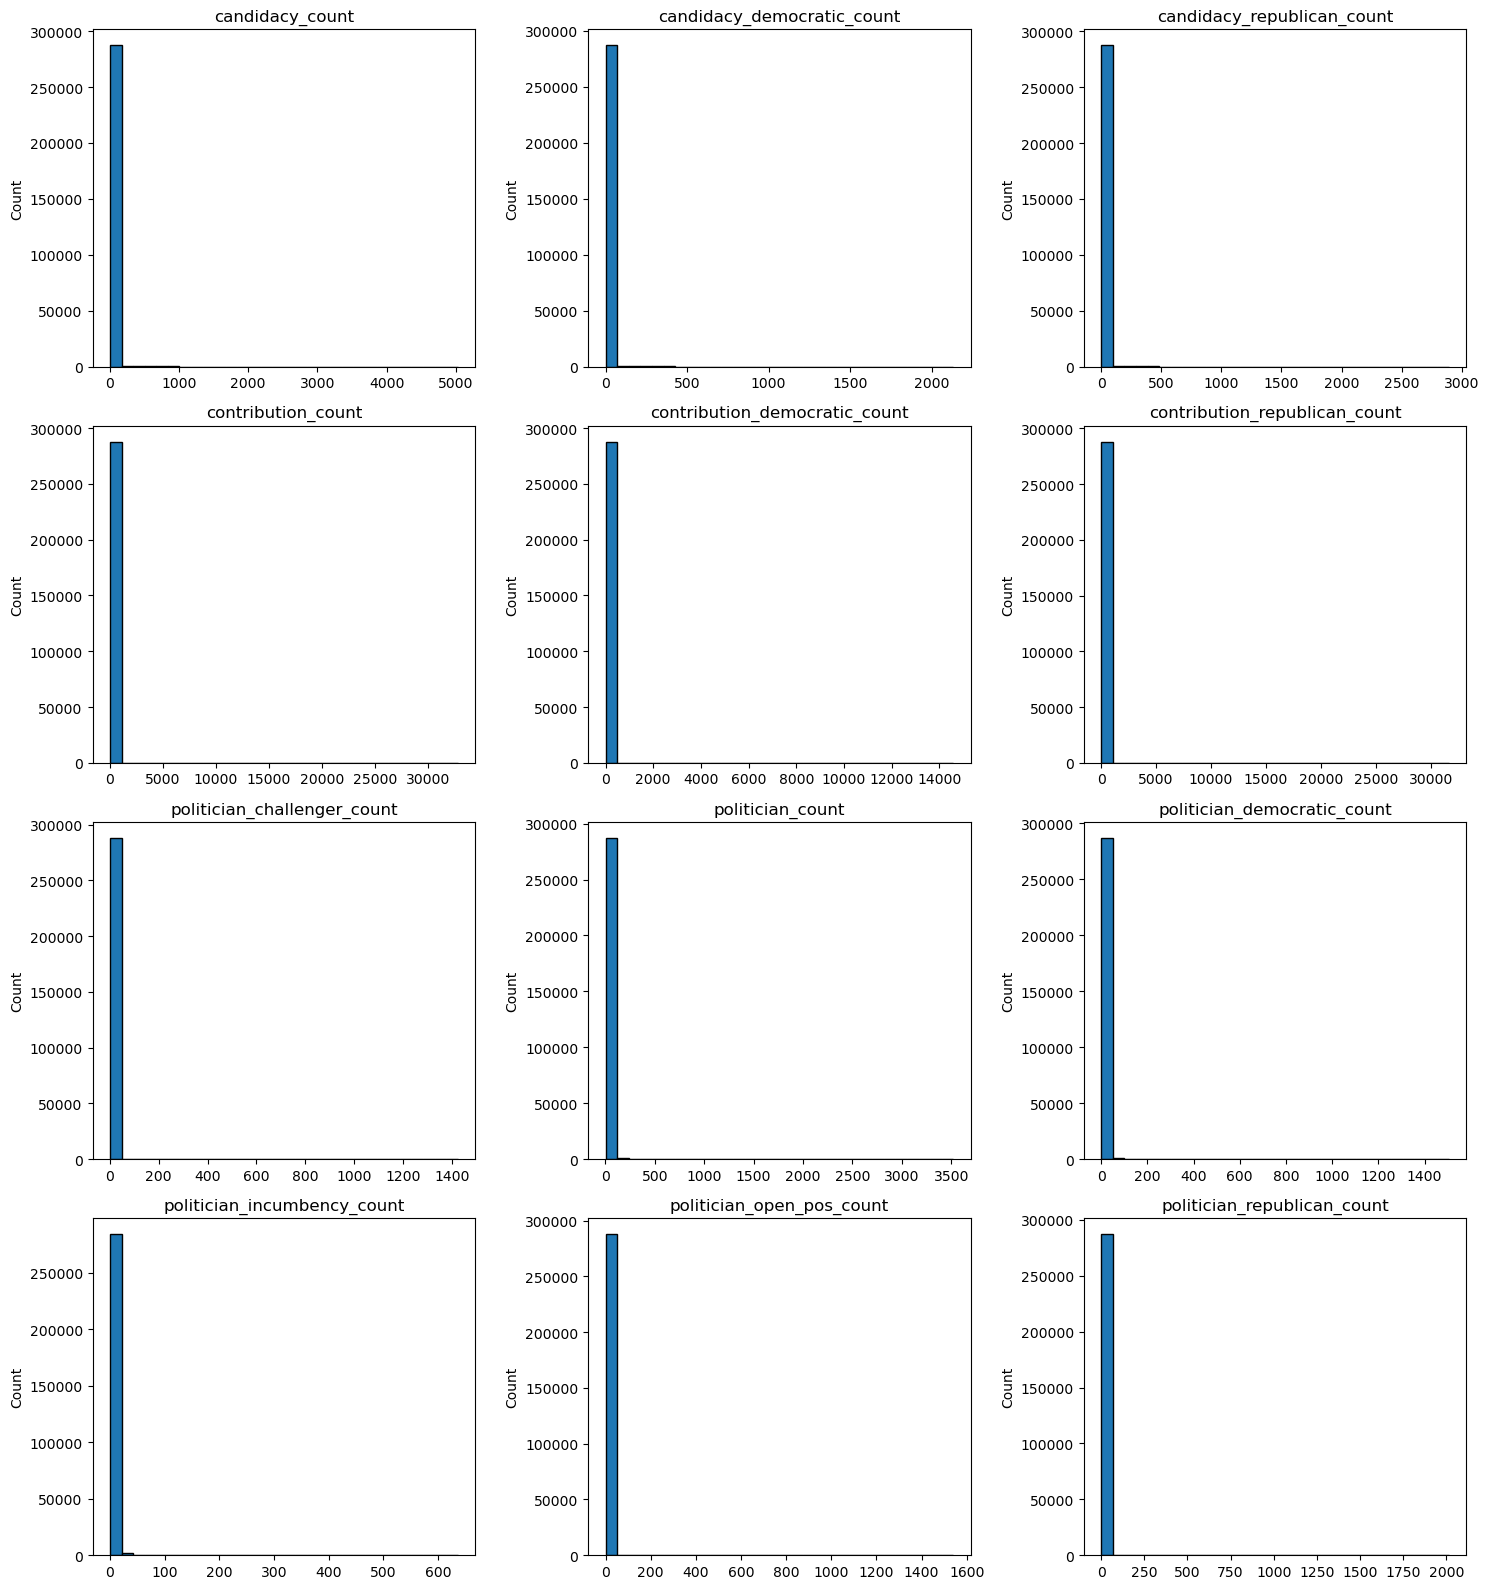

In [761]:
plot_histograms(all_data, count_cols)

In [762]:
# 1. Check how many duplicate rows exist
num_duplicates_all_data = all_data.duplicated().sum()
print(f"🔍 Number of duplicate rows in all_data: {num_duplicates_all_data}")

# 2. Drop duplicate records
all_data = all_data.drop_duplicates()
print(f"✅ Shape after removing Duplicates from all_data: {all_data.shape}")




🔍 Number of duplicate rows in all_data: 0
✅ Shape after removing Duplicates from all_data: (288080, 63)


## Drop redundant columns:
##### Since we're already capturing essential information in ratio columns, and numerator cols to show magnitude
##### Hence, dropping base columns: numerator, related to Candidacy, Politician, and Contribution count

#### Candidacy Ratios-
- candidacy_democratic_ratio = candidacy_democratic_count / candidacy_count
- candidacy_republican_ratio = candidacy_republican_count / candidacy_count

#### Politician Ratios- 
- politician_democratic_ratio = politician_democratic_count / politician_count
- politician_republican_ratio = politician_republican_count / politician_count
- politician_challenger_ratio = politician_challenger_count / politician_count
- politician_open_pos_ratio = politician_open_pos_count / politician_count
- politician_incumbency_ratio = politician_incumbency_count / politician_count

#### Contribution Count Ratios-
- contribution_democratic_count_ratio = contribution_democratic_count / contribution_count
- contribution_republican_count_ratio = contribution_republican_count / contribution_count

#### Contribution Sum Ratios (Money) -
- house_and_assembly_contribution_ratio = house_and_assembly_contributions_sum_2010_usd / contribution_sum_2010_usd
- senate_contribution_ratio = senate_contributions_sum_2010_usd / contribution_sum_2010_usd
- us_house_contribution_ratio = us_house_contributions_sum_2010_usd / contribution_sum_2010_usd
- us_senate_contribution_ratio = us_senate_contributions_sum_2010_usd / contribution_sum_2010_usd
- governor_contribution_ratio = governor_contributions_sum_2010_usd / contribution_sum_2010_usd

In [763]:
keep_cols = ['candidacy_count','politician_count','contribution_count']
drop_base_cols =[ 
                #Candidacy base cols
                'candidacy_democratic_count','candidacy_republican_count',
                #Politician base cols
                'politician_democratic_count','politician_republican_count','politician_challenger_count',
                'politician_open_pos_count','politician_incumbency_count',
                #Contribution count base cols
                'contribution_democratic_count','contribution_republican_count',
                
                #Contribution sum base cols
                'house_and_assembly_contributions_sum_2010_usd','senate_contributions_sum_2010_usd',
                'us_house_contributions_sum_2010_usd','us_senate_contributions_sum_2010_usd',
                'governor_contributions_sum_2010_usd'
            ]

In [764]:
all_data.drop(drop_base_cols, axis=1, inplace=True)

In [765]:
all_data.columns

Index(['specific_sector', 'state', 'contributor_type', 'winner_ratio',
       'candidacy_count', 'contribution_count', 'politician_count',
       'contribution_democratic_sum_2010_usd',
       'contribution_republican_sum_2010_usd', 'contribution_sum_2010_usd',
       'candidacy_democratic_ratio', 'candidacy_republican_ratio',
       'contribution_democratic_count_ratio',
       'contribution_republican_count_ratio', 'governor_contribution_ratio',
       'house_and_assembly_contribution_ratio', 'politician_challenger_ratio',
       'politician_democratic_ratio', 'politician_incumbency_ratio',
       'politician_open_pos_ratio', 'politician_republican_ratio',
       'senate_contribution_ratio', 'us_house_contribution_ratio',
       'us_senate_contribution_ratio', 'train_label', 'index', 'd_all',
       'd_win', 'd_weight_all', 'd_weight_win', 'greedy_modularity',
       'greedy_modularity_num', 'greedy_modularity_win',
       'greedy_modularity_win_num', 'louvain_communities',
       'l

In [766]:
num_vars =['candidacy_count', 'contribution_count',
       'politician_count', 'contribution_democratic_sum_2010_usd',
       'contribution_republican_sum_2010_usd', 'contribution_sum_2010_usd',
       'candidacy_democratic_ratio', 'candidacy_republican_ratio',
       'contribution_democratic_count_ratio',
       'contribution_republican_count_ratio', 'governor_contribution_ratio',
       'house_and_assembly_contribution_ratio', 'politician_challenger_ratio',
       'politician_democratic_ratio', 'politician_incumbency_ratio',
       'politician_open_pos_ratio', 'politician_republican_ratio',
       'senate_contribution_ratio', 'us_house_contribution_ratio',
       'us_senate_contribution_ratio']

# Compute Correlation with target variable

In [767]:

# 2. Compute Spearman’s ρ vs. winner_ratio in one go
spearman_corr = (
    all_data[num_vars + ['winner_ratio']]
      .corr(method='spearman')['winner_ratio']
      .drop('winner_ratio')
)

# 3. Sort and filter by absolute threshold
threshold = 0.01
spearman_corr = spearman_corr.sort_values(key=lambda x: x.abs(), ascending=False)
selected_feats = spearman_corr[spearman_corr.abs() >= threshold].index.tolist()

print("Spearman ρ for each log feature:\n", spearman_corr, "\n")
print(f"Selected features (|ρ| ≥ {threshold}): {selected_feats}")


Spearman ρ for each log feature:
 politician_incumbency_ratio              0.487020
politician_challenger_ratio             -0.320588
politician_open_pos_ratio               -0.253489
governor_contribution_ratio             -0.136454
house_and_assembly_contribution_ratio    0.092105
senate_contribution_ratio                0.079117
contribution_sum_2010_usd                0.068079
contribution_republican_sum_2010_usd     0.047857
contribution_count                      -0.034388
us_house_contribution_ratio             -0.032562
politician_count                        -0.024246
politician_democratic_ratio             -0.019526
politician_republican_ratio              0.019526
candidacy_republican_ratio               0.019497
candidacy_democratic_ratio              -0.019497
contribution_republican_count_ratio      0.019489
contribution_democratic_count_ratio     -0.019489
candidacy_count                          0.016934
contribution_democratic_sum_2010_usd     0.014608
us_senate_contri

## Check VIF among numerical columns

In [768]:
# 2) Compute VIFs
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = all_data[num_vars].dropna().astype(float)
vif_data = pd.DataFrame({
    "feature": selected_feats, 
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

print("\nVariance Inflation Factors:")
print(vif_data.sort_values("VIF", ascending=False))

/localdisk4/panwla/conda_envs/env3.10/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



Variance Inflation Factors:
                                  feature           VIF
8                      contribution_count           inf
9             us_house_contribution_ratio           inf
6               contribution_sum_2010_usd           inf
7    contribution_republican_sum_2010_usd           inf
16    contribution_democratic_count_ratio           inf
13             candidacy_republican_ratio           inf
5               senate_contribution_ratio  1.293078e+08
4   house_and_assembly_contribution_ratio  3.498670e+07
3             governor_contribution_ratio  3.484152e+07
0             politician_incumbency_ratio  1.968014e+01
2               politician_open_pos_ratio  1.859453e+01
14             candidacy_democratic_ratio  8.404005e+00
15    contribution_republican_count_ratio  8.380238e+00
12            politician_republican_ratio  5.142426e+00
1             politician_challenger_ratio  4.150999e+00
10                       politician_count  2.540598e+00
11            polit

In [769]:
# # Remove correlated features
# drop_cols = vif_data.loc[vif_data['VIF'] > 10, 'feature'].tolist()
# keep = [f for f in all_data.columns if f not in drop_cols]


## Create columns types

In [770]:
cat_vars

['general_sector_new', 'specific_sector', 'state', 'contributor_type']

In [771]:
tar_var = 'winner_ratio'
train_label = "train_label"
index_col = "index"

network_cols = [
    'd_all', 'd_win', 'd_weight_all', 'd_weight_win',
    'greedy_modularity', 'greedy_modularity_num',
    'greedy_modularity_win', 'greedy_modularity_win_num',
    'louvain_communities', 'louvain_communities_num',
    'louvain_communities_win', 'louvain_communities_win_num',
    'mean_deg_state_by_state', 'mean_deg_federal_by_state',
    'mean_deg_state_by_type', 'mean_deg_federal_by_type',
    'mean_deg_state_by_zip', 'mean_deg_federal_by_zip',
    'mean_deg_state_by_stz', 'mean_deg_federal_by_stz',
]
nw_cat_vars = ["greedy_modularity", "greedy_modularity_win",
             "louvain_communities", "louvain_communities_win"]
nw_num_vars = [col for col in network_cols if col not in nw_cat_vars]

train_num_vars = num_vars +  nw_num_vars 
train_vars =  num_vars +  nw_num_vars + cat_vars + nw_cat_vars +[train_label] + [index_col] + [tar_var]




# Impute missing values in network cols

In [772]:
all_data.loc[:,network_cols] = all_data.loc[:,network_cols].fillna(0)
with pd.option_context('display.max_rows', None):
    print(all_data.loc[:,network_cols].isna().sum())

d_all                          0
d_win                          0
d_weight_all                   0
d_weight_win                   0
greedy_modularity              0
greedy_modularity_num          0
greedy_modularity_win          0
greedy_modularity_win_num      0
louvain_communities            0
louvain_communities_num        0
louvain_communities_win        0
louvain_communities_win_num    0
mean_deg_state_by_state        0
mean_deg_federal_by_state      0
mean_deg_state_by_type         0
mean_deg_federal_by_type       0
mean_deg_state_by_zip          0
mean_deg_federal_by_zip        0
mean_deg_state_by_stz          0
mean_deg_federal_by_stz        0
dtype: int64


In [773]:
all_data.loc[:, network_cols].describe()

,d_all,d_win,d_weight_all,d_weight_win,greedy_modularity,greedy_modularity_num,greedy_modularity_win,greedy_modularity_win_num,louvain_communities,louvain_communities_num,louvain_communities_win,louvain_communities_win_num,mean_deg_state_by_state,mean_deg_federal_by_state,mean_deg_state_by_type,mean_deg_federal_by_type,mean_deg_state_by_zip,mean_deg_federal_by_zip,mean_deg_state_by_stz,mean_deg_federal_by_stz
count,288080.000000,288080.000000,288080.000000,288080.000000,288080.000000,288080.000000,288080.000000,288080.000000,288080.000000,288080.000000,288080.000000,288080.000000,2.880800e+05,2.880800e+05,2.880800e+05,2.880800e+05,288080.000000,288080.0,288080.0,288080.0
mean,40.670290,40.138121,31684.463955,28627.642713,0.325958,18.077971,0.325958,17.803173,1.206220,18.214545,1.113493,15.070335,2.564330e+07,1.105613e+09,2.829114e+07,1.258559e+09,432.111881,0.0,0.0,0.0
std,21.286996,21.150749,27315.226854,25025.440073,0.919705,9.978472,0.919705,9.691374,1.649575,10.352543,1.786701,10.080606,3.491730e+07,1.724217e+09,1.286042e+07,2.046474e+09,2849.237500,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.0
25%,36.000000,36.000000,4375.608411,3951.029503,0.000000,15.000000,0.000000,16.000000,0.000000,15.000000,0.000000,9.000000,0.000000e+00,5.465306e+06,2.275674e+07,3.756440e+08,0.000000,0.0,0.0,0.0
50%,51.000000,48.000000,28120.930853,23781.765825,0.000000,23.000000,0.000000,23.000000,2.000000,21.000000,0.000000,21.000000,4.108826e+06,3.817236e+08,2.275674e+07,3.756440e+08,0.000000,0.0,0.0,0.0
75%,54.000000,54.000000,54851.559883,51311.490531,1.000000,25.000000,1.000000,24.000000,3.000000,27.000000,2.000000,25.000000,5.522338e+07,8.678148e+08,2.275674e+07,3.756440e+08,0.000000,0.0,0.0,0.0
max,58.000000,58.000000,79114.910250,69057.010226,2.000000,25.000000,2.000000,24.000000,3.000000,27.000000,4.000000,25.000000,1.159220e+08,6.069102e+09,5.807314e+07,6.000895e+09,19219.205000,0.0,0.0,0.0


In [774]:
all_data.loc[:, nw_num_vars].describe()

,d_all,d_win,d_weight_all,d_weight_win,greedy_modularity_num,greedy_modularity_win_num,louvain_communities_num,louvain_communities_win_num,mean_deg_state_by_state,mean_deg_federal_by_state,mean_deg_state_by_type,mean_deg_federal_by_type,mean_deg_state_by_zip,mean_deg_federal_by_zip,mean_deg_state_by_stz,mean_deg_federal_by_stz
count,288080.000000,288080.000000,288080.000000,288080.000000,288080.000000,288080.000000,288080.000000,288080.000000,2.880800e+05,2.880800e+05,2.880800e+05,2.880800e+05,288080.000000,288080.0,288080.0,288080.0
mean,40.670290,40.138121,31684.463955,28627.642713,18.077971,17.803173,18.214545,15.070335,2.564330e+07,1.105613e+09,2.829114e+07,1.258559e+09,432.111881,0.0,0.0,0.0
std,21.286996,21.150749,27315.226854,25025.440073,9.978472,9.691374,10.352543,10.080606,3.491730e+07,1.724217e+09,1.286042e+07,2.046474e+09,2849.237500,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.0
25%,36.000000,36.000000,4375.608411,3951.029503,15.000000,16.000000,15.000000,9.000000,0.000000e+00,5.465306e+06,2.275674e+07,3.756440e+08,0.000000,0.0,0.0,0.0
50%,51.000000,48.000000,28120.930853,23781.765825,23.000000,23.000000,21.000000,21.000000,4.108826e+06,3.817236e+08,2.275674e+07,3.756440e+08,0.000000,0.0,0.0,0.0
75%,54.000000,54.000000,54851.559883,51311.490531,25.000000,24.000000,27.000000,25.000000,5.522338e+07,8.678148e+08,2.275674e+07,3.756440e+08,0.000000,0.0,0.0,0.0
max,58.000000,58.000000,79114.910250,69057.010226,25.000000,24.000000,27.000000,25.000000,1.159220e+08,6.069102e+09,5.807314e+07,6.000895e+09,19219.205000,0.0,0.0,0.0


In [775]:
for col in nw_cat_vars:
    print(f'#unique cats in {col} are {all_data.loc[:, col].nunique()}')
    print(f'unique cats in {col} are {all_data.loc[:, col].unique()}')

#unique cats in greedy_modularity are 4
unique cats in greedy_modularity are [ 1  0 -1  2]
#unique cats in greedy_modularity_win are 4
unique cats in greedy_modularity_win are [ 1  0 -1  2]
#unique cats in louvain_communities are 4
unique cats in louvain_communities are [ 0  3 -1  2]
#unique cats in louvain_communities_win are 5
unique cats in louvain_communities_win are [ 0  2  4 -1  1]


In [776]:
# nw_cols_to_drop = ["mean_deg_federal_by_zip","mean_deg_state_by_stz","mean_deg_federal_by_stz","mean_deg_federal_by_stz"]
# all_data.drop(nw_cols_to_drop, axis=1, inplace= True)
# nw_cols_to_impute = ["d_all","d_win","d_weight_all","d_weight_win", "mean_deg_state_by_state","mean_deg_federal_by_state",
#                      "mean_deg_state_by_type","mean_deg_federal_by_type","mean_deg_state_by_zip"]
# all_data.loc[:, nw_cols_to_impute] = all_data.loc[:, nw_cols_to_impute].fillna(0)

In [777]:

# for col in nw_cols_to_drop:
#     if col in network_cols:
#         network_cols.remove(col)
#         train_vars.remove(col)
#     else:
#         print(f'{col} is not present')
# #

## Correlation Analysis

In [778]:
import pandas as pd


# 1) Compute Spearman correlation with the target
corr = (
    all_data[train_num_vars + [tar_var]]
    .corr(method="spearman")[tar_var]
    .abs()                       # absolute value
    .drop(tar_var)                # drop the self‐correlation
    .sort_values(ascending=False)
)

# Option A: pick all with |ρ| > threshold
threshold = 0.04
selected_num_vars = corr[corr > threshold].index.tolist()

# Option B: or pick the top K
# K = 10
# selected_num_vars = corr.head(K).index.tolist()

print("Selected numeric features:", selected_num_vars)
corr

Selected numeric features: ['politician_incumbency_ratio', 'politician_challenger_ratio', 'politician_open_pos_ratio', 'governor_contribution_ratio', 'mean_deg_federal_by_type', 'mean_deg_state_by_type', 'house_and_assembly_contribution_ratio', 'senate_contribution_ratio', 'contribution_sum_2010_usd', 'louvain_communities_win_num', 'contribution_republican_sum_2010_usd']


politician_incumbency_ratio              0.487020
politician_challenger_ratio              0.320588
politician_open_pos_ratio                0.253489
governor_contribution_ratio              0.136454
mean_deg_federal_by_type                 0.104701
mean_deg_state_by_type                   0.104701
house_and_assembly_contribution_ratio    0.092105
senate_contribution_ratio                0.079117
contribution_sum_2010_usd                0.068079
louvain_communities_win_num              0.065029
contribution_republican_sum_2010_usd     0.047857
contribution_count                       0.034388
us_house_contribution_ratio              0.032562
politician_count                         0.024246
louvain_communities_num                  0.021300
greedy_modularity_win_num                0.019605
greedy_modularity_num                    0.019605
politician_republican_ratio              0.019526
politician_democratic_ratio              0.019526
candidacy_democratic_ratio               0.019497


In [779]:
# 2) Compute VIFs
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = all_data[selected_num_vars].dropna().astype(float)
vif_data = pd.DataFrame({
    "feature": selected_num_vars, 
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

print("\nVariance Inflation Factors:")
print(vif_data.sort_values("VIF", ascending=False))


Variance Inflation Factors:
                                  feature        VIF
4                mean_deg_federal_by_type  29.395126
5                  mean_deg_state_by_type  20.089241
8               contribution_sum_2010_usd  13.524262
10   contribution_republican_sum_2010_usd  13.524204
2               politician_open_pos_ratio   8.311117
0             politician_incumbency_ratio   8.283315
1             politician_challenger_ratio   5.054611
3             governor_contribution_ratio   1.899784
6   house_and_assembly_contribution_ratio   1.690844
9             louvain_communities_win_num   1.631793
7               senate_contribution_ratio   1.582131


# Important features selection

In [780]:
# train_num_vars = selected_num_vars
# train_vars =  selected_num_vars + cat_vars + nw_cat_vars +[train_label] + [index_col] + [tar_var]

In [781]:
# Subset data based on final variables
# all_data =  all_data.loc[:, train_vars]

all_data =  all_data.loc[:, train_vars]


In [782]:
# take backup of data
all_data_bkp = all_data.copy()

In [790]:

all_data = all_data_bkp.copy()

## Check data ambiguity

In [784]:
# from collections import Counter

# df = all_data.copy()

# # 1) Duplicate headers in the DataFrame itself
# dup_df_cols = df.columns[df.columns.duplicated()]
# if len(dup_df_cols):
#     print("⚠️ Duplicate columns in your DataFrame:", dup_df_cols.unique().tolist())
# else:
#     print("✅ No duplicate column names in your DataFrame.")

# # 2) cat_vars that aren’t actually in the DataFrame
# missing_vars = [c for c in cat_vars if c not in df.columns]
# if missing_vars:
#     print("⚠️ These cat_vars are not in the DataFrame:", missing_vars)
# else:
#     print("✅ All cat_vars are present in the DataFrame.")

# # 3) cat_vars list itself contains duplicates?
# dup_in_list = [c for c,count in Counter(cat_vars).items() if count>1]
# if dup_in_list:
#     print("⚠️ These cat_vars are duplicated in your list:", dup_in_list)
# else:
#     print("✅ No duplicates in your cat_vars list.")

# # 4) For extra insurance, check that slicing df[cat_vars] returns exactly len(cat_vars) columns
# slice_cols = df[cat_vars].columns
# if slice_cols.duplicated().any():
#     print("⚠️ df[cat_vars] has duplicated column labels:", slice_cols[slice_cols.duplicated()].tolist())
# else:
#     print("✅ df[cat_vars] slice has unique column labels.")


In [785]:
cat_vars, nw_cat_vars

(['general_sector_new', 'specific_sector', 'state', 'contributor_type'],
 ['greedy_modularity',
  'greedy_modularity_win',
  'louvain_communities',
  'louvain_communities_win'])

In [795]:
all_data.drop("general_sector_new", axis=1, inplace= True)

In [793]:
"general_sector_new" in all_data.columns

True

In [796]:
# finally, fill any remaining NaNs
all_data.fillna(0, inplace=True)

all_data = pd.get_dummies(
    all_data,
    columns=[
            # "specific_sector",
             "general_sector_new",
              "state", "contributor_type",
             "greedy_modularity", "greedy_modularity_win",
             "louvain_communities", "louvain_communities_win"]
)

# 1. Base: Tree based models: RandomForest

RF trees: 100%|██████████| 100/100 [04:45<00:00,  2.86s/it]


Training MSE: 0.0191
Validation RMSE: 0.0838


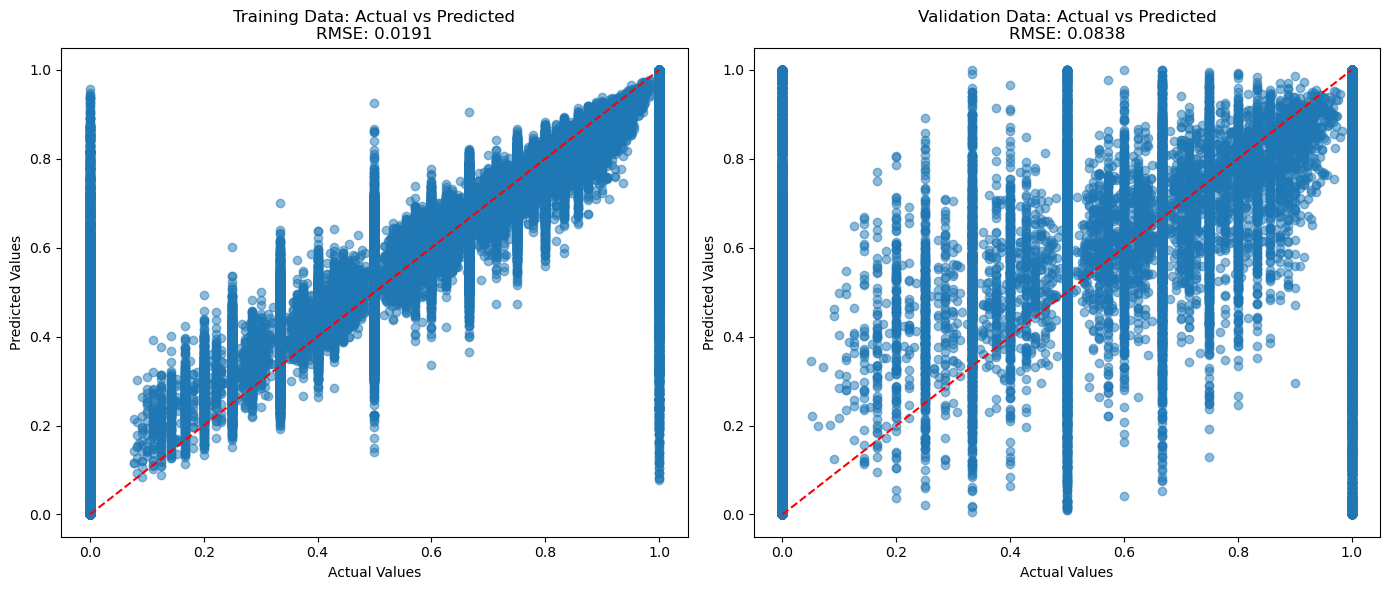

Submission saved → sample_submission_combined_RF.csv
Plot saved → actual_vs_predicted.png


In [797]:
# ------------------------------------------------------------------
# 8. Train/test/validation split for modeling
# ------------------------------------------------------------------
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# First separate the training data from the final test data
train_df = all_data[all_data["train_label"] == 1].drop(columns=["index"])
test_df = all_data[all_data["train_label"] == 0]

# Now split the training data into train and validation sets (80% train, 20% validation)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Prepare X and y for each set
y_train = train_df["winner_ratio"]
X_train = train_df.drop(columns=["winner_ratio", "train_label"])

y_val = val_df["winner_ratio"]
X_val = val_df.drop(columns=["winner_ratio", "train_label"])

test_idx = test_df["index"]
X_test = test_df.drop(columns=["winner_ratio", "train_label", "index"])

# ------------------------------------------------------------------
# 9. Train Random Forest model directly (no hyperparameter tuning)
# ------------------------------------------------------------------
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import numpy as np

# Create and train a Random Forest model with default parameters
from tqdm.auto import tqdm
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=1,
    warm_start=True,   # allow growing more trees without discarding previous ones
    random_state=42,
    n_jobs=-1
)

pbar = tqdm(total=100, desc="RF trees")
for i in range(1, 101):
    rf.set_params(n_estimators=i)
    rf.fit(X_train, y_train)
    pbar.update(1)
pbar.close()


# Make predictions on train and validation sets
train_pred = rf.predict(X_train)
val_pred = rf.predict(X_val)

# Calculate RMSE for both sets
train_mse = metrics.mean_squared_error(y_train, train_pred)
val_mse = metrics.mean_squared_error(y_val, val_pred)

print(f"Training MSE: {train_mse:,.4f}")
print(f"Validation RMSE: {val_mse:,.4f}")

# ------------------------------------------------------------------
# Plot actual vs predicted values for train and validation data
# ------------------------------------------------------------------
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Training data plot
ax1.scatter(y_train, train_pred, alpha=0.5)
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
ax1.set_xlabel('Actual Values')
ax1.set_ylabel('Predicted Values')
ax1.set_title(f'Training Data: Actual vs Predicted\nRMSE: {train_mse:.4f}')

# Validation data plot
ax2.scatter(y_val, val_pred, alpha=0.5)
ax2.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
ax2.set_xlabel('Actual Values')
ax2.set_ylabel('Predicted Values')
ax2.set_title(f'Validation Data: Actual vs Predicted\nRMSE: {val_mse:.4f}')

plt.tight_layout()
plt.savefig('actual_vs_predicted.png')
plt.show()

# ------------------------------------------------------------------
# 10. Predict test & save submission
# ------------------------------------------------------------------
test_pred = rf.predict(X_test)
submission = pd.DataFrame({"index": test_idx, "winner_ratio": test_pred})
submission.to_csv("sample_submission_combined_RF.csv", index=False)
print("Submission saved → sample_submission_combined_RF.csv")
print("Plot saved → actual_vs_predicted.png")

In [1947]:
# Kept city, zipcode
# Fitting RF: 100%|██████████| 1000/1000 [02:25<00:00,  6.87it/s]
# Training MSE:   0.0664
# Validation MSE: 0.0854

# Removed zipcode
# Fitting RF: 100%|██████████| 1000/1000 [02:08<00:00,  7.76it/s]
# Training MSE:   0.0718
# Validation MSE: 0.0848

# Removed city
# Fitting RF: 100%|██████████| 1000/1000 [02:08<00:00,  7.76it/s]
# Training MSE:   0.0718
# Validation MSE: 0.0848

# Removed both city and zipcode
# Fitting RF: 100%|██████████| 1000/1000 [02:08<00:00,  7.76it/s]
# Training MSE:   0.0718
# Validation MSE: 0.0848

## selected features
#  Validation MSE: 0.0838

## selected features
#  Validation MSE: 0.0882

### general_sector_new:
# RF trees: 100%|██████████| 100/100 [02:13<00:00,  1.33s/it]
# Training MSE: 0.0210
# Validation RMSE: 0.0835

### specific_sector:
# Training MSE: 0.0191
# Validation RMSE: 0.0838

In [ ]:
hjgjhg

In [1948]:
asw

NameError: name 'asw' is not defined

In [744]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn import metrics

import category_encoders as ce
import xgboost as xgb

# ───────────────────────────────────────────────────────────────────────────────
# 1 · Data split & encoding (as before)
# ───────────────────────────────────────────────────────────────────────────────
target   = "winner_ratio"
cat_vars = ["state", "contributor_type", "general_sector"]
# binary_flag_cols = [...]  # your 0/1 flags

# split
train_df = all_data[all_data["train_label"] == 1].drop(columns=["index"])
test_df  = all_data[all_data["train_label"] == 0]
train_df, val_df = train_test_split(train_df, test_size=0.20, random_state=42)

y_train, y_val = train_df[target], val_df[target]

# numeric vs flags
num_vars = [
    c for c in train_df.columns
    if c not in cat_vars + selected_flag_cols + [target, "train_label"]
]

# target‐encode cats
te = ce.TargetEncoder(cols=cat_vars, smoothing=0.3)
te.fit(train_df[cat_vars], y_train)
train_cat = te.transform(train_df[cat_vars])
val_cat   = te.transform(val_df[cat_vars])
test_cat  = te.transform(test_df[cat_vars])

# stack features
X_train = np.hstack([
    train_df[num_vars].values,
    train_df[selected_flag_cols].values,
    train_cat.values
])
X_val   = np.hstack([
    val_df[num_vars].values,
    val_df[selected_flag_cols].values,
    val_cat.values
])
X_test  = np.hstack([
    test_df[num_vars].values,
    test_df[selected_flag_cols].values,
    test_cat.values
])

# ───────────────────────────────────────────────────────────────────────────────
# 2 · Run xgb.cv to find best n_estimators
# ───────────────────────────────────────────────────────────────────────────────
dtrain = xgb.DMatrix(X_train, label=y_train)

params = {
    "objective":        "reg:squarederror",
    "eta":              0.05,
    "max_depth":        7,
    "subsample":        0.8,
    "colsample_bytree": 0.8,
    "min_child_weight": 3,
    "seed":             42,
}

print("▶️  Running xgb.cv…")
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round       = 1000,
    nfold                 = 5,
    metrics               = ("rmse",),
    early_stopping_rounds = 50,
    seed                  = 42,
    verbose_eval          = 100,
)

best_n = len(cv_results)
print(f"✅  CV complete. Best n_estimators = {best_n}\n")

# ───────────────────────────────────────────────────────────────────────────────
# 3 · Fit final XGBRegressor
# ───────────────────────────────────────────────────────────────────────────────
xgb_model = xgb.XGBRegressor(
    **params,
    n_estimators = best_n,
    n_jobs       = -1,
    verbosity    = 1,
)

print("▶️  Fitting final XGBRegressor…")
xgb_model.fit(X_train, y_train)
print("✅  Fit complete.\n")

# ───────────────────────────────────────────────────────────────────────────────
# 4 · Evaluate
# ───────────────────────────────────────────────────────────────────────────────
train_pred = xgb_model.predict(X_train)
val_pred   = xgb_model.predict(X_val)

train_mse = metrics.mean_squared_error(y_train, train_pred)
val_mse   = metrics.mean_squared_error(y_val,   val_pred)

print(f"Training MSE:   {train_mse:,.4f}")
print(f"Validation MSE: {val_mse:,.4f}")

# ───────────────────────────────────────────────────────────────────────────────
# 5 · Feature importances
# ───────────────────────────────────────────────────────────────────────────────
feat_names = num_vars + binary_flag_cols + train_cat.columns.tolist()
imp = pd.Series(xgb_model.feature_importances_, index=feat_names) \
        .sort_values(ascending=False)

print("\nTop 10 features by importance:")
print(imp.head(10))

# ───────────────────────────────────────────────────────────────────────────────
# 6 · Plot actual vs. predicted
# ───────────────────────────────────────────────────────────────────────────────
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.scatter(y_train, train_pred, alpha=0.5)
ax1.plot([y_train.min(), y_train.max()],
         [y_train.min(), y_train.max()], "r--")
ax1.set(title=f"Train RMSE {train_rmse:.4f}", xlabel="Actual", ylabel="Pred")

ax2.scatter(y_val, val_pred, alpha=0.5)
ax2.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()], "r--")
ax2.set(title=f"Val RMSE {val_rmse:.4f}", xlabel="Actual", ylabel="Pred")

plt.tight_layout()
plt.show()

# ───────────────────────────────────────────────────────────────────────────────
# 7 · Predict & save submission
# ───────────────────────────────────────────────────────────────────────────────
test_pred  = xgb_model.predict(X_test)
submission = pd.DataFrame({"index": test_df["index"], "winner_ratio": test_pred})
submission.to_csv("sample_submission_xgb.csv", index=False)
print("Submission saved → sample_submission_xgb.csv")


▶️  Running xgb.cv…
[0]	train-rmse:0.40328+0.00018	test-rmse:0.40333+0.00073
[100]	train-rmse:0.29945+0.00038	test-rmse:0.30435+0.00180
[200]	train-rmse:0.29007+0.00043	test-rmse:0.29900+0.00189
[300]	train-rmse:0.28346+0.00046	test-rmse:0.29626+0.00168
[400]	train-rmse:0.27796+0.00041	test-rmse:0.29450+0.00162
[500]	train-rmse:0.27349+0.00028	test-rmse:0.29344+0.00163
[600]	train-rmse:0.26925+0.00028	test-rmse:0.29246+0.00160
[700]	train-rmse:0.26562+0.00025	test-rmse:0.29191+0.00156
[800]	train-rmse:0.26229+0.00028	test-rmse:0.29148+0.00146
[900]	train-rmse:0.25910+0.00036	test-rmse:0.29116+0.00142
[999]	train-rmse:0.25619+0.00038	test-rmse:0.29091+0.00140
✅  CV complete. Best n_estimators = 1000

▶️  Fitting final XGBRegressor…
✅  Fit complete.

Training RMSE:   0.2604
Validation RMSE: 0.2900


ValueError: Length of values (46) does not match length of index (18)

In [633]:
all_data.columns

Index(['politician_incumbency_ratio', 'politician_incumbency_count_log',
       'politician_challenger_ratio', 'politician_challenger_count_log',
       'politician_open_pos_ratio', 'politician_open_pos_count_log',
       'governor_contribution_ratio',
       'governor_contributions_sum_2010_usd_log',
       'house_and_assembly_contribution_ratio',
       'house_and_assembly_contributions_sum_2010_usd_log',
       'senate_contribution_ratio', 'senate_contributions_sum_2010_usd_log',
       'contribution_sum_2010_usd_log',
       'contribution_republican_sum_2010_usd_log',
       'contribution_republican_sum_2010_usd_is_refund',
       'contribution_sum_2010_usd_is_refund',
       'governor_contributions_sum_2010_usd_is_refund',
       'house_and_assembly_contributions_sum_2010_usd_is_refund',
       'senate_contributions_sum_2010_usd_is_refund',
       'us_senate_contributions_sum_2010_usd_is_refund',
       'contribution_republican_sum_2010_usd_is0',
       'contribution_sum_2010_usd_

# 1. Base: ElasticNetCV Model


/localdisk4/panwla/conda_envs/env3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.256483211776867, tolerance: 1.863968489857432
  model = cd_fast.sparse_enet_coordinate_descent(
/localdisk4/panwla/conda_envs/env3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.74338644902491, tolerance: 1.8648661424812802
  model = cd_fast.sparse_enet_coordinate_descent(
/localdisk4/panwla/conda_envs/env3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.444744201233334, tolerance: 2.333164836020936
  model = cd_fast.sparse_enet_coordinate_descent(


Best alpha : 0.00014873521072935117
Best l1ratio : 0.1
Training RMSE:   0.1157
Validation RMSE: 0.1151


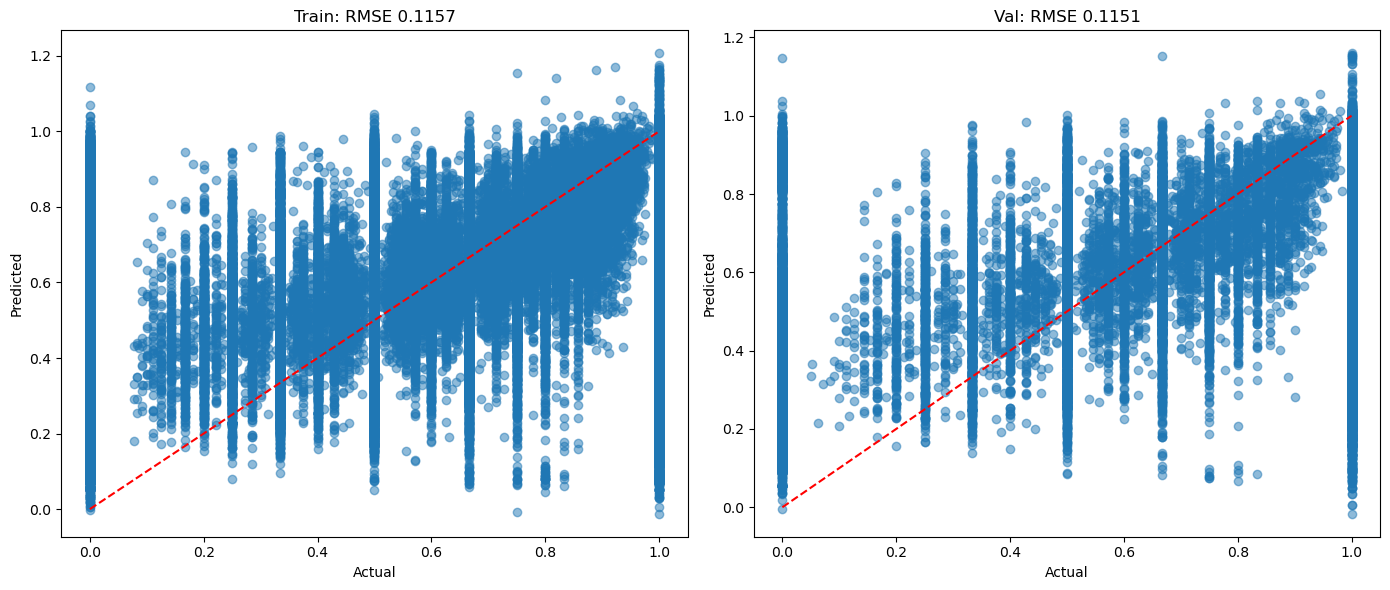

Submission saved → sample_submission_enet.csv
Plot saved → actual_vs_predicted_enet.png


In [552]:

# ───────────────────────────────────────────────────────────────────────────────
# 0 · Imports
# ───────────────────────────────────────────────────────────────────────────────
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler, OneHotEncoder
from sklearn.compose         import ColumnTransformer
from sklearn.linear_model    import ElasticNetCV
from sklearn                 import metrics

# ───────────────────────────────────────────────────────────────────────────────
# 1 · Data split  (assumes `all_data`, `cat_vars`, `binary_flag_cols`)
# ───────────────────────────────────────────────────────────────────────────────
target = "winner_ratio"

train_df = all_data[all_data["train_label"] == 1].drop(columns=["index"])
test_df  = all_data[all_data["train_label"] == 0]

train_df, val_df = train_test_split(train_df, test_size=0.20, random_state=42)

y_train = train_df[target]
y_val   = val_df[target]

# columns for different treatments
# num_vars = [
#     c for c in train_df.columns
#     if c not in cat_vars + selected_flag_cols + [target, "train_label"]
# ]

# ───────────────────────────────────────────────────────────────────────────────
# 2 · Pre-processor   (scale nums, pass flags, one-hot cats)
# ───────────────────────────────────────────────────────────────────────────────
pre = ColumnTransformer(
    transformers=[
        ("num",  StandardScaler(),               final_num_vars),
        ("flag", "passthrough",                  selected_flag_cols),
        ("ohe",  OneHotEncoder(handle_unknown="ignore"), cat_vars),
    ],
    remainder="drop",
)

X_train = pre.fit_transform(train_df)
X_val   = pre.transform(val_df)
X_test  = pre.transform(test_df.drop(columns=[target, "train_label", "index"]))

# ───────────────────────────────────────────────────────────────────────────────
# 3 · ElasticNetCV  (alpha × l1_ratio grid)
# ───────────────────────────────────────────────────────────────────────────────
enet = ElasticNetCV(
    l1_ratio = [0.1, 0.5, 0.9, 1.0],
    alphas   = np.logspace(-4, 1, 30),
    cv       = 5,
    n_jobs   = -1,
    random_state = 42,
)

enet.fit(X_train, y_train)

print("Best alpha :", enet.alpha_)
print("Best l1ratio :", enet.l1_ratio_)

# ───────────────────────────────────────────────────────────────────────────────
# 4 · Evaluate
# ───────────────────────────────────────────────────────────────────────────────
train_pred = enet.predict(X_train)
val_pred   = enet.predict(X_val)

train_rmse = metrics.mean_squared_error(y_train, train_pred)
val_rmse   = metrics.mean_squared_error(y_val,   val_pred)

print(f"Training RMSE:   {train_rmse:,.4f}")
print(f"Validation RMSE: {val_rmse:,.4f}")

# ───────────────────────────────────────────────────────────────────────────────
# 5 · Plot Actual vs Predicted
# ───────────────────────────────────────────────────────────────────────────────
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.scatter(y_train, train_pred, alpha=0.5)
ax1.plot([y_train.min(), y_train.max()],
         [y_train.min(), y_train.max()], "r--")
ax1.set(title=f"Train: RMSE {train_rmse:.4f}",
        xlabel="Actual", ylabel="Predicted")

ax2.scatter(y_val, val_pred, alpha=0.5)
ax2.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()], "r--")
ax2.set(title=f"Val: RMSE {val_rmse:.4f}",
        xlabel="Actual", ylabel="Predicted")

plt.tight_layout()
plt.savefig("actual_vs_predicted_enet.png")
plt.show()

# ───────────────────────────────────────────────────────────────────────────────
# 6 · Predict test & save submission
# ───────────────────────────────────────────────────────────────────────────────
test_idx  = test_df["index"]
test_pred = enet.predict(X_test)

submission = pd.DataFrame({"index": test_idx, "winner_ratio": test_pred})
submission.to_csv("sample_submission_enet.csv", index=False)

print("Submission saved → sample_submission_enet.csv")
print("Plot saved → actual_vs_predicted_enet.png")


# 1. ElasticNet with dense embeddings for categorical columnns

Epoch 020 ▶ train 0.0807 · val 0.1479
Epoch 040 ▶ train 0.0763 · val 0.1696
🛑 Early stopping at epoch 52


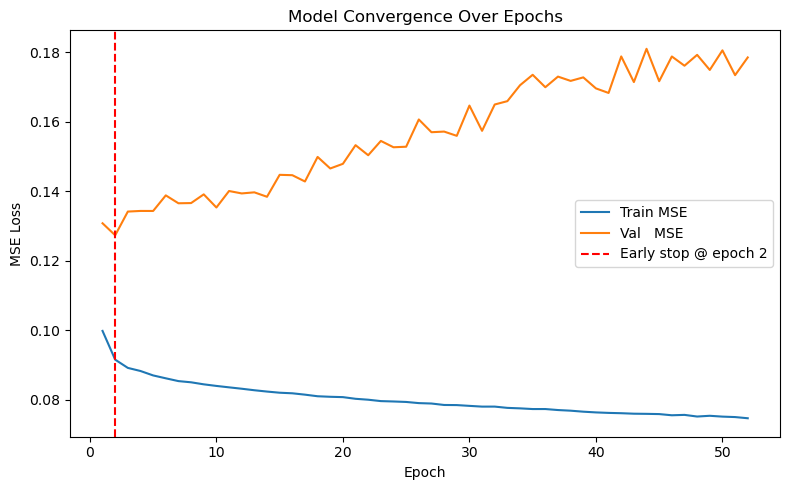

In [553]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import StandardScaler

# ───────────────────────────────────────────────────────────────────────────────
# 0 · Configuration
# ───────────────────────────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ───────────────────────────────────────────────────────────────────────────────
# 1 · Load & split
# ───────────────────────────────────────────────────────────────────────────────
# assumes all_data is already in memory
df_train = all_data[all_data["train_label"] == 1].drop(columns=["index"])
df_test  = all_data[all_data["train_label"] == 0]

df_train, df_val = train_test_split(df_train, test_size=0.20, random_state=42)

# ───────────────────────────────────────────────────────────────────────────────
# 2 · Numeric preprocessing
# ───────────────────────────────────────────────────────────────────────────────

scaler = StandardScaler().fit(df_train[final_num_vars])

def make_numeric(df):
    nums  = scaler.transform(df[final_num_vars])
    flags = df[selected_flag_cols].values.astype("float32")
    return np.hstack([nums, flags]).astype("float32")

# ───────────────────────────────────────────────────────────────────────────────
# 3 · Dataset & DataLoader
# ───────────────────────────────────────────────────────────────────────────────
class TabDataset(Dataset):
    def __init__(self, df):
        cats = (
            df[cat_vars]
            .astype("category")
            .apply(lambda s: s.cat.codes)
            .values
        ).astype("int64")
        self.cats = cats
        self.nums = make_numeric(df)
        self.y    = df[target].values.astype("float32")

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.cats[idx], dtype=torch.long),
            torch.tensor(self.nums[idx], dtype=torch.float32),
            torch.tensor(self.y[idx],    dtype=torch.float32),
        )

train_ds = TabDataset(df_train)
val_ds   = TabDataset(df_val)

train_dl = DataLoader(train_ds, batch_size=512, shuffle=True)
val_dl   = DataLoader(val_ds,   batch_size=1024)

# ───────────────────────────────────────────────────────────────────────────────
# 4 · Model Definition
# ───────────────────────────────────────────────────────────────────────────────
def emb_dim(n_cat):
    return int(min(50, round(1.6 * np.sqrt(n_cat))))

cat_sizes = [df_train[c].nunique() for c in cat_vars]
emb_dims   = [(n, emb_dim(n)) for n in cat_sizes]

class WideDeep(nn.Module):
    def __init__(self, emb_dims, n_num):
        super().__init__()
        self.embs   = nn.ModuleList([nn.Embedding(n, d) for n, d in emb_dims])
        self.bn_num = nn.BatchNorm1d(n_num)

        in_dim = sum(d for _, d in emb_dims) + n_num
        self.fc1  = nn.Linear(in_dim, 128)
        self.bn1  = nn.BatchNorm1d(128)
        self.fc2  = nn.Linear(128, 64)
        self.bn2  = nn.BatchNorm1d(64)
        self.fc3  = nn.Linear(64, 32)
        self.bn3  = nn.BatchNorm1d(32)
        self.out  = nn.Linear(32, 1)

    def forward(self, x_cat, x_num):
        embs = [emb(x_cat[:, i]) for i, emb in enumerate(self.embs)]
        x    = torch.cat(embs + [self.bn_num(x_num)], dim=1)
        x    = F.relu(self.bn1(self.fc1(x)))
        x    = F.relu(self.bn2(self.fc2(x)))
        x    = F.relu(self.bn3(self.fc3(x)))
        return torch.sigmoid(self.out(x)).squeeze(1)

model = WideDeep(emb_dims, train_ds.nums.shape[1]).to(device)

# ───────────────────────────────────────────────────────────────────────────────
# 5 · Training Loop with Early Stopping
# ───────────────────────────────────────────────────────────────────────────────
opt      = torch.optim.Adam(model.parameters(), lr=3e-3)
loss_fn  = nn.MSELoss()
patience = 50
best_val, wait = float("inf"), 0
train_hist, val_hist = [], []

for epoch in range(1, 201):
    # — train —
    model.train()
    tr_loss = 0.0
    for xc, xn, y in train_dl:
        xc, xn, y = xc.to(device), xn.to(device), y.to(device)
        opt.zero_grad()
        preds = model(xc, xn)
        loss  = loss_fn(preds, y)
        loss.backward()
        opt.step()
        tr_loss += loss.item() * y.size(0)
    tr_loss /= len(train_ds)
    train_hist.append(tr_loss)

    # — validate —
    model.eval()
    vl_loss = 0.0
    with torch.no_grad():
        for xc, xn, y in val_dl:
            xc, xn, y = xc.to(device), xn.to(device), y.to(device)
            preds = model(xc, xn)
            vl_loss += loss_fn(preds, y).item() * y.size(0)
    vl_loss /= len(val_ds)
    val_hist.append(vl_loss)
    if epoch % 20 ==0:
        print(f"Epoch {epoch:03d} ▶ train {tr_loss:.4f} · val {vl_loss:.4f}")

    # — early stopping —
    if vl_loss < best_val - 1e-5:
        best_val, wait, best_state = vl_loss, 0, model.state_dict()
    else:
        wait += 1
        if wait >= patience:
            print(f"🛑 Early stopping at epoch {epoch}")
            break

# restore best weights
model.load_state_dict(best_state)

# ───────────────────────────────────────────────────────────────────────────────
# 6 · Convergence Plot
# ───────────────────────────────────────────────────────────────────────────────
epochs = np.arange(1, len(train_hist) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_hist, label="Train MSE")
plt.plot(epochs, val_hist,   label="Val   MSE")
stop_epoch = len(val_hist) - wait
plt.axvline(stop_epoch, color="r", linestyle="--",
            label=f"Early stop @ epoch {stop_epoch}")

plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Model Convergence Over Epochs")
plt.legend()
plt.tight_layout()
plt.show()


# 1. Base Neural Network

In [555]:
# # ───────────────────────────────────────────────────────────────────────────────
# # 0 · Imports & GPU/CPU setup
# # ───────────────────────────────────────────────────────────────────────────────
# import numpy as np, pandas as pd, matplotlib.pyplot as plt
# import torch, torch.nn as nn, torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing  import StandardScaler

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # ───────────────────────────────────────────────────────────────────────────────
# # 1 · Data split (assumes `all_data` already in memory)
# # ───────────────────────────────────────────────────────────────────────────────
# target        = "winner_ratio"


# train_df = all_data[all_data["train_label"] == 1].drop(columns=["index"])
# test_df  = all_data[all_data["train_label"] == 0]

# train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# # ───────────────────────────────────────────────────────────────────────────────
# # 2 · Numeric preprocessing: scale nums, keep refund flags raw
# # ───────────────────────────────────────────────────────────────────────────────
# scaler = StandardScaler().fit(train_df[final_num_vars])

# def make_numeric(df):
#     nums_scaled = scaler.transform(df[final_num_vars])
#     flags       = df[selected_flag_cols].values.astype("float32")
#     return np.hstack([nums_scaled, flags]).astype("float32")

# # ───────────────────────────────────────────────────────────────────────────────
# # 3 · Torch Dataset
# # ───────────────────────────────────────────────────────────────────────────────
# class TabDataset(Dataset):
#     def __init__(self, df):
#         # categorical → category codes ( -1 for unseen val becomes -1+1 = 0 later )
#         self.cats = (df[cat_vars].astype("category")
#                      .apply(lambda s: s.cat.codes).values).astype("int64")
#         self.nums = make_numeric(df)
#         self.y    = df[target].values.astype("float32")

#     def __len__(self):  return len(self.y)

#     def __getitem__(self, idx):
#         return (
#             torch.tensor(self.cats[idx], dtype=torch.long),
#             torch.tensor(self.nums[idx], dtype=torch.float32),
#             torch.tensor(self.y[idx],   dtype=torch.float32)
#         )

# train_ds = TabDataset(train_df)
# val_ds   = TabDataset(val_df)
# train_dl = DataLoader(train_ds, batch_size=512, shuffle=True)
# val_dl   = DataLoader(val_ds,   batch_size=1024)

# # ───────────────────────────────────────────────────────────────────────────────
# # 4 · Model: embeddings + numeric MLP
# # ───────────────────────────────────────────────────────────────────────────────
# def emb_dim(n):               # heuristic: min(50, 1.6*√n)
#     return int(min(50, round(1.6 * np.sqrt(n))))

# print("cat_vars:", cat_vars)

# cat_sizes = [train_df[c].nunique() for c in cat_vars]
# print("cat_sizes:", cat_sizes)


# emb_dims  = [(n, emb_dim(n)) for n in cat_sizes]

# print("emb_dims:", emb_dims)

# class WideDeep(nn.Module):
#     def __init__(self, emb_dims, n_num):
#         super().__init__()
#         self.embs = nn.ModuleList([nn.Embedding(n, d) for n, d in emb_dims])
#         self.bn_num = nn.BatchNorm1d(n_num)

#         in_dim = sum(d for _, d in emb_dims) + n_num
#         self.fc1 = nn.Linear(in_dim, 128)
#         self.fc2 = nn.Linear(128, 64)
#         self.fc3 = nn.Linear(64, 32)
#         self.out = nn.Linear(32, 1)

#         self.bn1 = nn.BatchNorm1d(128)
#         self.bn2 = nn.BatchNorm1d(64)
#         self.bn3 = nn.BatchNorm1d(32)

#     def forward(self, x_cat, x_num):
#         x_cat = [emb(x_cat[:, i]) for i, emb in enumerate(self.embs)]
#         x = torch.cat(x_cat + [self.bn_num(x_num)], dim=1)
#         x = F.relu(self.bn1(self.fc1(x)))
#         x = F.relu(self.bn2(self.fc2(x)))
#         x = F.relu(self.bn3(self.fc3(x)))
#         return torch.sigmoid(self.out(x)).squeeze(1)

# model = WideDeep(emb_dims, train_ds.nums.shape[1]).to(device)

# # ───────────────────────────────────────────────────────────────────────────────
# # 5 · Training with early stopping (patience = 50, max 200 epochs)
# # ───────────────────────────────────────────────────────────────────────────────
# opt      = torch.optim.Adam(model.parameters(), lr=3e-3)
# loss_fn  = nn.MSELoss()
# patience = 50
# best_val, best_state, wait = np.inf, None, 0
# train_hist, val_hist = [], []

# for epoch in range(1, 501):
#     # train ----------------------------------------------------
#     model.train(); train_loss = 0
#     for xc, xn, y in train_dl:
#         xc, xn, y = xc.to(device), xn.to(device), y.to(device)
#         opt.zero_grad()
#         pred = model(xc, xn)
#         loss = loss_fn(pred, y)
#         loss.backward(); opt.step()
#         train_loss += loss.item() * len(y)
#     train_loss /= len(train_ds); train_hist.append(train_loss)

#     # validate -------------------------------------------------
#     model.eval(); val_loss = 0
#     with torch.no_grad():
#         for xc, xn, y in val_dl:
#             xc, xn, y = xc.to(device), xn.to(device), y.to(device)
#             val_loss += loss_fn(model(xc, xn), y).item() * len(y)
#     val_loss /= len(val_ds); val_hist.append(val_loss)

#     print(f"Epoch {epoch:03d}: train {train_loss:.4f}  • val {val_loss:.4f}")

#     # early stopping ------------------------------------------
#     if val_loss < best_val - 1e-5:
#         best_val, best_state, wait = val_loss, model.state_dict(), 0
#     else:
#         wait += 1
#         if wait >= patience:
#             print("🛑 Early stopping triggered")
#             break

# model.load_state_dict(best_state)

# # ───────────────────────────────────────────────────────────────────────────────
# # 6 · Convergence plot
# # ───────────────────────────────────────────────────────────────────────────────
# plt.figure(figsize=(7,4))
# plt.plot(train_hist, label="train")
# plt.plot(val_hist,   label="val")
# plt.axvline(len(val_hist)-wait, ls="--", c="r")
# plt.xlabel("Epoch"); plt.ylabel("MSE loss"); plt.title("Convergence")
# plt.legend(); plt.tight_layout(); plt.show()


Epoch 001 ▶ train 0.1007 · val 0.1220
Epoch 002 ▶ train 0.0910 · val 0.1204
Epoch 003 ▶ train 0.0889 · val 0.1207
Epoch 004 ▶ train 0.0877 · val 0.1230
Epoch 005 ▶ train 0.0870 · val 0.1234
Epoch 006 ▶ train 0.0867 · val 0.1263
Epoch 007 ▶ train 0.0860 · val 0.1245
Epoch 008 ▶ train 0.0856 · val 0.1293
Epoch 009 ▶ train 0.0853 · val 0.1254
Epoch 010 ▶ train 0.0849 · val 0.1326
Epoch 011 ▶ train 0.0845 · val 0.1356
Epoch 012 ▶ train 0.0846 · val 0.1333
Epoch 013 ▶ train 0.0841 · val 0.1336
Epoch 014 ▶ train 0.0838 · val 0.1374
Epoch 015 ▶ train 0.0837 · val 0.1361
Epoch 016 ▶ train 0.0834 · val 0.1332
Epoch 017 ▶ train 0.0833 · val 0.1377
Epoch 018 ▶ train 0.0830 · val 0.1351
Epoch 019 ▶ train 0.0829 · val 0.1355
Epoch 020 ▶ train 0.0828 · val 0.1373
Epoch 021 ▶ train 0.0826 · val 0.1386
Epoch 022 ▶ train 0.0823 · val 0.1368
Epoch 023 ▶ train 0.0822 · val 0.1428
Epoch 024 ▶ train 0.0820 · val 0.1421
Epoch 025 ▶ train 0.0817 · val 0.1431
Epoch 026 ▶ train 0.0818 · val 0.1397
Epoch 027 ▶ 

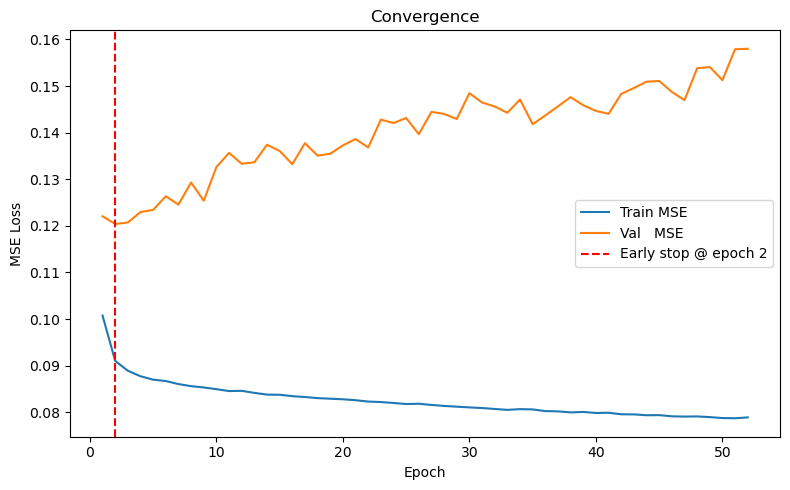


Final Train MSE: 0.076415
Final  Val MSE:  0.157985


In [556]:
# ───────────────────────────────────────────────────────────────────────────────
# 0 · Imports & GPU/CPU setup
# ───────────────────────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import StandardScaler
from sklearn.metrics        import mean_squared_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ───────────────────────────────────────────────────────────────────────────────
# 1 · Data split (assumes `all_data` already in memory)
# ───────────────────────────────────────────────────────────────────────────────
target        = "winner_ratio"

train_df = all_data[all_data["train_label"] == 1].drop(columns=["index"])
test_df  = all_data[all_data["train_label"] == 0]

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# ───────────────────────────────────────────────────────────────────────────────
# 2 · Numeric preprocessing: scale selected numeric + keep flags raw
# ───────────────────────────────────────────────────────────────────────────────
# final_num_vars and selected_flag_cols from your feature‐selection step
scaler = StandardScaler().fit(train_df[final_num_vars])

def make_numeric(df):
    nums_scaled = scaler.transform(df[final_num_vars])
    flags       = df[selected_flag_cols].values.astype("float32")
    return np.hstack([nums_scaled, flags]).astype("float32")

# ───────────────────────────────────────────────────────────────────────────────
# 3 · Torch Dataset & DataLoader
# ───────────────────────────────────────────────────────────────────────────────
class TabDataset(Dataset):
    def __init__(self, df):
        self.cats = (
            df[cat_vars]
            .astype("category")
            .apply(lambda s: s.cat.codes)
            .values
        ).astype("int64")
        self.nums = make_numeric(df)
        self.y    = df[target].values.astype("float32")

    def __len__(self): 
        return len(self.y)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.cats[idx], dtype=torch.long),
            torch.tensor(self.nums[idx], dtype=torch.float32),
            torch.tensor(self.y[idx],    dtype=torch.float32),
        )

train_ds = TabDataset(train_df)
val_ds   = TabDataset(val_df)

train_dl = DataLoader(train_ds, batch_size=512, shuffle=True)
val_dl   = DataLoader(val_ds,   batch_size=1024)

# ───────────────────────────────────────────────────────────────────────────────
# 4 · Model: embeddings + numeric MLP
# ───────────────────────────────────────────────────────────────────────────────
def emb_dim(n):               
    return int(min(50, round(1.6 * np.sqrt(n))))

cat_sizes = [train_df[c].nunique() for c in cat_vars]
emb_dims   = [(n, emb_dim(n)) for n in cat_sizes]

class WideDeep(nn.Module):
    def __init__(self, emb_dims, n_num):
        super().__init__()
        self.embs   = nn.ModuleList([nn.Embedding(n, d) for n, d in emb_dims])
        self.bn_num = nn.BatchNorm1d(n_num)

        in_dim     = sum(d for _, d in emb_dims) + n_num
        self.fc1    = nn.Linear(in_dim, 128)
        self.bn1    = nn.BatchNorm1d(128)
        self.fc2    = nn.Linear(128, 64)
        self.bn2    = nn.BatchNorm1d(64)
        self.fc3    = nn.Linear(64, 32)
        self.bn3    = nn.BatchNorm1d(32)
        self.out    = nn.Linear(32, 1)

    def forward(self, x_cat, x_num):
        embs = [emb(x_cat[:, i]) for i, emb in enumerate(self.embs)]
        x    = torch.cat(embs + [self.bn_num(x_num)], dim=1)
        x    = F.relu(self.bn1(self.fc1(x)))
        x    = F.relu(self.bn2(self.fc2(x)))
        x    = F.relu(self.bn3(self.fc3(x)))
        return torch.sigmoid(self.out(x)).squeeze(1)

model = WideDeep(emb_dims, train_ds.nums.shape[1]).to(device)

# ───────────────────────────────────────────────────────────────────────────────
# 5 · Training with early stopping (patience = 50, max 500 epochs)
# ───────────────────────────────────────────────────────────────────────────────
opt      = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-5)
loss_fn  = nn.MSELoss()
patience = 50
best_val, best_state, wait = np.inf, None, 0
train_hist, val_hist = [], []

for epoch in range(1, 501):
    # train
    model.train(); tr_loss = 0
    for xc, xn, y in train_dl:
        xc, xn, y = xc.to(device), xn.to(device), y.to(device)
        opt.zero_grad()
        preds = model(xc, xn)
        loss  = loss_fn(preds, y)
        loss.backward(); opt.step()
        tr_loss += loss.item() * len(y)
    tr_loss /= len(train_ds); train_hist.append(tr_loss)

    # validate
    model.eval(); vl_loss = 0
    with torch.no_grad():
        for xc, xn, y in val_dl:
            xc, xn, y = xc.to(device), xn.to(device), y.to(device)
            vl_loss += loss_fn(model(xc, xn), y).item() * len(y)
    vl_loss /= len(val_ds); val_hist.append(vl_loss)

    print(f"Epoch {epoch:03d} ▶ train {tr_loss:.4f} · val {vl_loss:.4f}")

    # early stopping
    if vl_loss < best_val - 1e-5:
        best_val, best_state, wait = vl_loss, model.state_dict(), 0
    else:
        wait += 1
        if wait >= patience:
            print(f"🛑 Early stopping at epoch {epoch}")
            break

# restore best
model.load_state_dict(best_state)

# ───────────────────────────────────────────────────────────────────────────────
# 6 · Convergence plot
# ───────────────────────────────────────────────────────────────────────────────
epochs = np.arange(1, len(train_hist) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_hist, label="Train MSE")
plt.plot(epochs, val_hist,   label="Val   MSE")
stop_epoch = len(val_hist) - wait
plt.axvline(stop_epoch, color="r", linestyle="--",
            label=f"Early stop @ epoch {stop_epoch}")

plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Convergence")
plt.legend()
plt.tight_layout()
plt.show()

# ───────────────────────────────────────────────────────────────────────────────
# 7 · Final MSE on Train & Val
# ───────────────────────────────────────────────────────────────────────────────
# gather predictions
model.eval()
with torch.no_grad():
    # train set
    all_preds_tr, all_y_tr = [], []
    for xc, xn, y in train_dl:
        xc, xn = xc.to(device), xn.to(device)
        all_preds_tr.append(model(xc, xn).cpu().numpy())
        all_y_tr.append(y.numpy())
    preds_tr = np.concatenate(all_preds_tr)
    y_tr     = np.concatenate(all_y_tr)

    # val set
    all_preds_val, all_y_val = [], []
    for xc, xn, y in val_dl:
        xc, xn = xc.to(device), xn.to(device)
        all_preds_val.append(model(xc, xn).cpu().numpy())
        all_y_val.append(y.numpy())
    preds_val = np.concatenate(all_preds_val)
    y_val_arr = np.concatenate(all_y_val)

# compute and print final MSE
final_train_mse = mean_squared_error(y_tr, preds_tr)
final_val_mse   = mean_squared_error(y_val_arr, preds_val)
print(f"\nFinal Train MSE: {final_train_mse:.6f}")
print(f"Final  Val MSE:  {final_val_mse:.6f}")


Epoch 001 ▶ train 0.0990 · val 0.1164
Epoch 002 ▶ train 0.0909 · val 0.1198
Epoch 003 ▶ train 0.0887 · val 0.1213
Epoch 004 ▶ train 0.0876 · val 0.1264
Epoch 005 ▶ train 0.0868 · val 0.1241
Epoch 006 ▶ train 0.0863 · val 0.1280
Epoch 007 ▶ train 0.0858 · val 0.1268
Epoch 008 ▶ train 0.0854 · val 0.1296
Epoch 009 ▶ train 0.0850 · val 0.1313
Epoch 010 ▶ train 0.0847 · val 0.1306
Epoch 011 ▶ train 0.0845 · val 0.1339
Epoch 012 ▶ train 0.0841 · val 0.1317
Epoch 013 ▶ train 0.0839 · val 0.1319
Epoch 014 ▶ train 0.0837 · val 0.1316
Epoch 015 ▶ train 0.0834 · val 0.1346
Epoch 016 ▶ train 0.0831 · val 0.1371
Epoch 017 ▶ train 0.0831 · val 0.1382
Epoch 018 ▶ train 0.0827 · val 0.1349
Epoch 019 ▶ train 0.0825 · val 0.1373
Epoch 020 ▶ train 0.0822 · val 0.1378
Epoch 021 ▶ train 0.0823 · val 0.1363
Epoch 022 ▶ train 0.0820 · val 0.1388
Epoch 023 ▶ train 0.0817 · val 0.1383
Epoch 024 ▶ train 0.0816 · val 0.1377
Epoch 025 ▶ train 0.0813 · val 0.1360
Epoch 026 ▶ train 0.0814 · val 0.1431
Epoch 027 ▶ 

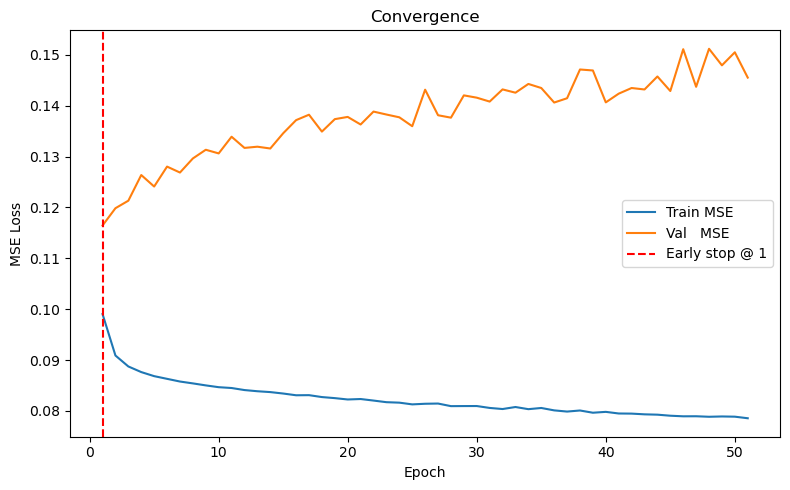

Final Train  MSE: 0.0769777002664316
Final Val    MSE: 0.1455089374948409


In [624]:
# ───────────────────────────────────────────────────────────────────────────────
# 0 · Imports & GPU/CPU setup
# ───────────────────────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import StandardScaler
from sklearn.metrics        import mean_squared_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# # ───────────────────────────────────────────────────────────────────────────────
# # 1 · Config: which columns to embed, numeric & flags
# # ───────────────────────────────────────────────────────────────────────────────
# target            = "winner_ratio"
# cat_vars          = ["state", "contributor_type", "general_sector_new"]
# # after your Spearman/flag‐selection step:
# final_num_vars    = [...]  # e.g. ['politician_incumbency_count_log', ...]
# selected_flag_cols= [...]  # e.g. ['politician_incumbency_count_is0', ...]

# ───────────────────────────────────────────────────────────────────────────────
# 2 · Data split
# ───────────────────────────────────────────────────────────────────────────────
df_train = all_data[all_data["train_label"] == 1].drop(columns=["index"])
df_test  = all_data[all_data["train_label"] == 0]

df_train, df_val = train_test_split(df_train, test_size=0.20, random_state=42)


# ───────────────────────────────────────────────────────────────────────────────
# 3 · Numeric preprocessing (scale nums, pass flags)
# ───────────────────────────────────────────────────────────────────────────────
scaler = StandardScaler().fit(df_train[final_num_vars])

def make_numeric(df):
    nums  = scaler.transform(df[final_num_vars])
    flags = df[selected_flag_cols].values.astype("float32")
    return np.hstack([nums, flags]).astype("float32")


# ───────────────────────────────────────────────────────────────────────────────
# 4 · Dataset + DataLoader
# ───────────────────────────────────────────────────────────────────────────────
class TabDataset(Dataset):
    def __init__(self, df):
        # category → integer codes
        cats = df[cat_vars].astype("category").apply(lambda s: s.cat.codes)
        self.cats = cats.values.astype("int64")
        self.nums = make_numeric(df)
        self.y    = df[target].values.astype("float32")

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.cats[idx], dtype=torch.long),
            torch.tensor(self.nums[idx], dtype=torch.float32),
            torch.tensor(self.y[idx],    dtype=torch.float32),
        )

train_ds = TabDataset(df_train)
val_ds   = TabDataset(df_val)

train_dl = DataLoader(train_ds, batch_size=512, shuffle=True)
val_dl   = DataLoader(val_ds,   batch_size=1024)


# ───────────────────────────────────────────────────────────────────────────────
# 5 · Model definition (embeddings + MLP)
# ───────────────────────────────────────────────────────────────────────────────
def emb_dim(n): 
    return int(min(50, round(1.6 * np.sqrt(n))))

# how many categories in each
cat_sizes = [ df_train[c].nunique() for c in cat_vars ]
emb_dims   = [ (size, emb_dim(size)) for size in cat_sizes ]

class WideDeep(nn.Module):
    def __init__(self, emb_dims, n_numeric):
        super().__init__()
        # embedding tables
        self.embs   = nn.ModuleList([ nn.Embedding(n_cat, d) 
                                      for n_cat, d in emb_dims ])
        # batch‐norm on numeric+flag block
        self.bn_num = nn.BatchNorm1d(n_numeric)

        # hidden layers
        in_dim = sum(d for _, d in emb_dims) + n_numeric
        self.fc1  = nn.Linear(in_dim, 128); self.bn1 = nn.BatchNorm1d(128)
        self.fc2  = nn.Linear(128, 64);    self.bn2 = nn.BatchNorm1d(64)
        self.fc3  = nn.Linear(64, 32);     self.bn3 = nn.BatchNorm1d(32)
        self.out  = nn.Linear(32, 1)

    def forward(self, x_cat, x_num):
        # look up embeddings & concat
        x_emb = [ emb(x_cat[:,i]) for i, emb in enumerate(self.embs) ]
        x = torch.cat(x_emb + [ self.bn_num(x_num) ], dim=1)
        # MLP
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        return torch.sigmoid(self.out(x)).squeeze(1)

model = WideDeep(emb_dims, train_ds.nums.shape[1]).to(device)


# ───────────────────────────────────────────────────────────────────────────────
# 6 · Training loop w/ early stopping & convergence tracking
# ───────────────────────────────────────────────────────────────────────────────
opt      = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-5)
loss_fn  = nn.MSELoss()
patience = 50

best_val, best_state, wait = np.inf, None, 0
train_hist, val_hist = [], []

for epoch in range(1, 501):
    # — train —
    model.train(); tr_loss = 0.0
    for xc, xn, y in train_dl:
        xc, xn, y = xc.to(device), xn.to(device), y.to(device)
        opt.zero_grad()
        pred = model(xc, xn)
        loss = loss_fn(pred, y)
        loss.backward(); opt.step()
        tr_loss += loss.item() * len(y)
    tr_loss /= len(train_ds); train_hist.append(tr_loss)

    # — validate —
    model.eval(); vl_loss = 0.0
    with torch.no_grad():
        for xc, xn, y in val_dl:
            xc, xn, y = xc.to(device), xn.to(device), y.to(device)
            vl_loss += loss_fn(model(xc, xn), y).item() * len(y)
    vl_loss /= len(val_ds); val_hist.append(vl_loss)

    print(f"Epoch {epoch:03d} ▶ train {tr_loss:.4f} · val {vl_loss:.4f}")

    # — early stopping —
    if vl_loss < best_val - 1e-5:
        best_val, best_state, wait = vl_loss, model.state_dict(), 0
    else:
        wait += 1
        if wait >= patience:
            print(f"🛑 Early stopping at epoch {epoch}")
            break

# restore best
model.load_state_dict(best_state)

# ───────────────────────────────────────────────────────────────────────────────
# 7 · Convergence plot
# ───────────────────────────────────────────────────────────────────────────────
epochs = np.arange(1, len(train_hist) + 1)
plt.figure(figsize=(8,5))
plt.plot(epochs, train_hist, label="Train MSE")
plt.plot(epochs, val_hist,   label="Val   MSE")
stop_ep = len(val_hist) - wait
plt.axvline(stop_ep, color="r", linestyle="--", label=f"Early stop @ {stop_ep}")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.title("Convergence")
plt.legend(); plt.tight_layout(); plt.show()

# ───────────────────────────────────────────────────────────────────────────────
# 8 · Final MSE
# ───────────────────────────────────────────────────────────────────────────────
model.eval()
with torch.no_grad():
    # train
    preds_tr = model(
        *[t.to(device) for t in train_ds[:][0:2]]
    ).cpu().numpy()
    y_tr     = train_df[target].values
    # val
    preds_val= model(
        *[t.to(device) for t in val_ds[:][0:2]]
    ).cpu().numpy()
    y_val_arr= val_df[target].values

print("Final Train  MSE:", mean_squared_error(y_tr,    preds_tr))
print("Final Val    MSE:", mean_squared_error(y_val_arr,preds_val))


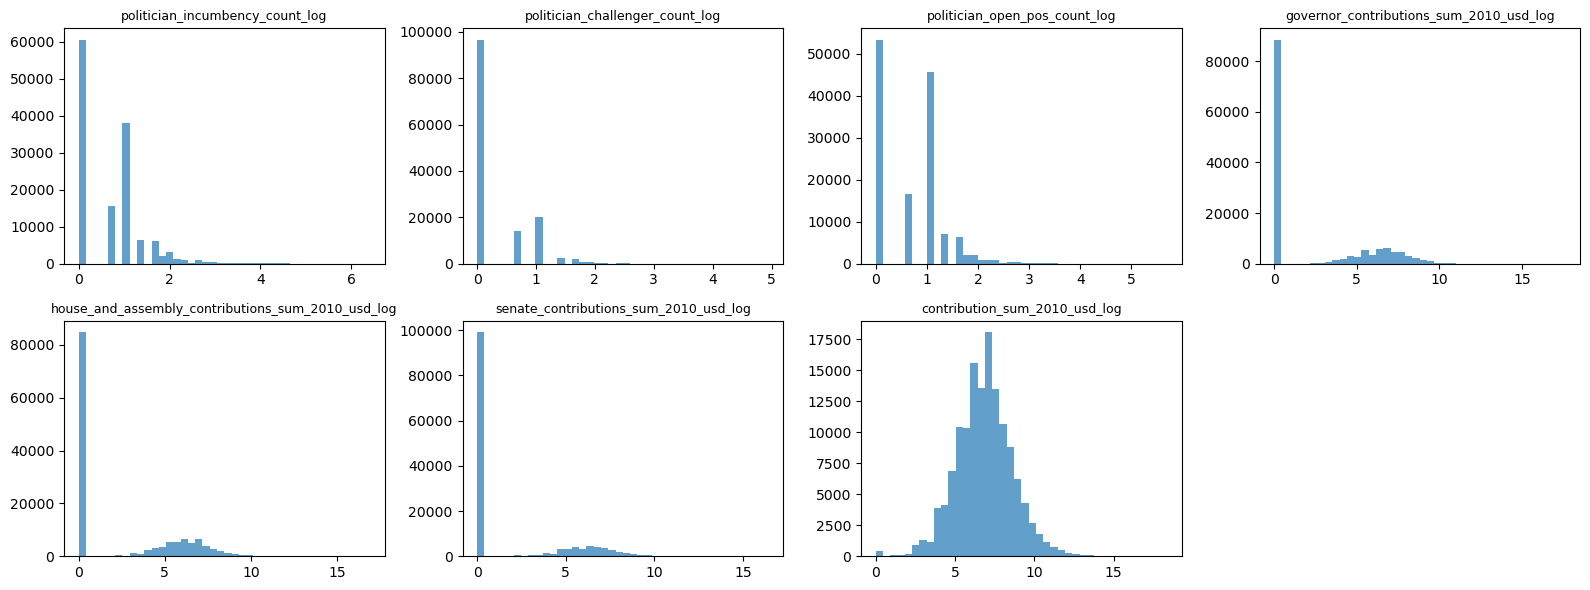

In [479]:
import matplotlib.pyplot as plt
import numpy as np

def hist_grid(df, cols, bins=40, n_per_row=4, show_kurt=False):
    """Simple grid of histograms for any list of columns."""
    n = len(cols); n_rows = int(np.ceil(n / n_per_row))
    fig, axs = plt.subplots(n_rows, n_per_row,
                            figsize=(4*n_per_row, 3*n_rows),
                            squeeze=False)
    for ax, col in zip(axs.ravel(), cols):
        s = df[col].dropna()
        ax.hist(s, bins=bins, alpha=0.7)
        ax.set_title(col, fontsize=9)
        if show_kurt:
            ax.text(0.95, 0.9,
                    f"kurt={s.kurtosis():.1f}",
                    transform=ax.transAxes,
                    ha="right", va="top", fontsize=8)
    for ax in axs.ravel()[len(cols):]:
        ax.axis("off")
    plt.tight_layout()
    plt.show()
    
skewness = train_df.select_dtypes("number").skew().sort_values(ascending=False)
hist_grid(train_df, final_num_vars)


In [ ]:
all_data[final_num_vars].describe().to_csv("all_data_num_vars.csv", index= False)

In [243]:
import copy, numpy as np, torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm.auto import tqdm

# ───────────────────────────────────────────────────────────────────────────────
# 1) eval_loss helper
# ───────────────────────────────────────────────────────────────────────────────
def eval_loss(model, dataloader, loss_fn):
    model.eval()
    total, n = 0.0, 0
    with torch.no_grad():
        for x_cat, x_num, y in dataloader:
            x_cat, x_num, y = x_cat.to(device), x_num.to(device), y.to(device)
            pred = model(x_cat, x_num)
            total += loss_fn(pred, y).item() * y.size(0)
            n += y.size(0)
    return total / n

# assume these exist from prior steps:
#   model, val_dl, val_ds, num_vars, refund_cols, cat_vars, train_df, val_df, scaler, WideDeep, emb_dim, device

loss_fn  = nn.MSELoss()
baseline = eval_loss(model, val_dl, loss_fn)

# ───────────────────────────────────────────────────────────────────────────────
# 2) Permutation importances
# ───────────────────────────────────────────────────────────────────────────────
importances = {}

# a) numeric + flag features
all_num    = num_vars + refund_cols
val_cats   = val_ds.cats.copy()
val_nums   = val_ds.nums.copy()
val_targets= val_ds.y.copy()

for i, feat in enumerate(all_num):
    nums_perm = val_nums.copy()
    np.random.shuffle(nums_perm[:, i])
    ds_perm = TensorDataset(
        torch.tensor(val_cats,    dtype=torch.long),
        torch.tensor(nums_perm,    dtype=torch.float32),
        torch.tensor(val_targets,  dtype=torch.float32),
    )
    dl_perm    = DataLoader(ds_perm, batch_size=1024)
    perm_loss  = eval_loss(model, dl_perm, loss_fn)
    importances[feat] = perm_loss - baseline

# b) categorical features
for j, feat in enumerate(cat_vars):
    cats_perm = val_cats.copy()
    np.random.shuffle(cats_perm[:, j])
    ds_perm   = TensorDataset(
        torch.tensor(cats_perm,  dtype=torch.long),
        torch.tensor(val_nums,   dtype=torch.float32),
        torch.tensor(val_targets,dtype=torch.float32),
    )
    dl_perm   = DataLoader(ds_perm, batch_size=1024)
    perm_loss = eval_loss(model, dl_perm, loss_fn)
    importances[feat] = perm_loss - baseline

# ───────────────────────────────────────────────────────────────────────────────
# 3) Select top-K
# ───────────────────────────────────────────────────────────────────────────────
K = 10
top_feats    = [f for f,_ in sorted(importances.items(), key=lambda x: x[1], reverse=True)[:K]]
print("Top features:", top_feats)

selected_cat  = [f for f in top_feats if f in cat_vars]
selected_num  = [f for f in top_feats if f in num_vars]
selected_flag = [f for f in top_feats if f in refund_cols]

# ───────────────────────────────────────────────────────────────────────────────
# 4) New scaler for just the selected numeric features
# ───────────────────────────────────────────────────────────────────────────────
from sklearn.preprocessing import StandardScaler
scaler2 = StandardScaler().fit(train_df[selected_num])

# ───────────────────────────────────────────────────────────────────────────────
# 5) SubsetDataset
# ───────────────────────────────────────────────────────────────────────────────
class SubsetDataset(Dataset):
    def __init__(self, df):
        cats = df[selected_cat].astype("category").apply(lambda s: s.cat.codes).values
        nums = scaler2.transform(df[selected_num])
        flags= df[selected_flag].values.astype("float32")
        self.cats = cats.astype("int64")
        self.nums = np.hstack([nums, flags]).astype("float32")
        self.y    = df[target].values.astype("float32")
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return (
            torch.tensor(self.cats[idx], dtype=torch.long),
            torch.tensor(self.nums[idx], dtype=torch.float32),
            torch.tensor(self.y[idx],    dtype=torch.float32),
        )

train_ds2 = SubsetDataset(train_df)
val_ds2   = SubsetDataset(val_df)
train_dl2 = DataLoader(train_ds2, batch_size=512, shuffle=True)
val_dl2   = DataLoader(val_ds2,   batch_size=1024)

# ───────────────────────────────────────────────────────────────────────────────
# 6) Rebuild & retrain model2 on subset
# ───────────────────────────────────────────────────────────────────────────────
cat_sizes2 = [train_df[c].nunique() for c in selected_cat]
emb_dims2  = [(n, emb_dim(n)) for n in cat_sizes2]
model2     = WideDeep(emb_dims2, len(selected_num) + len(selected_flag)).to(device)

opt, best_val, wait = torch.optim.Adam(model2.parameters(), lr=3e-3), float("inf"), 0
patience = 50

for epoch in range(1, 201):
    # train
    model2.train(); tl = 0
    for xc, xn, y in train_dl2:
        xc, xn, y = xc.to(device), xn.to(device), y.to(device)
        opt.zero_grad()
        loss = loss_fn(model2(xc, xn), y)
        loss.backward(); opt.step()
        tl += loss.item() * len(y)
    tl /= len(train_ds2)

    # val
    model2.eval(); vl = 0
    with torch.no_grad():
        for xc, xn, y in val_dl2:
            xc, xn, y = xc.to(device), xn.to(device), y.to(device)
            vl += loss_fn(model2(xc, xn), y).item() * len(y)
    vl /= len(val_ds2)

    print(f"[Subset] Epoch {epoch:03d} ▶ tr {tl:.4f} · val {vl:.4f}")

    if vl < best_val - 1e-5:
        best_val, wait, best_state2 = vl, 0, model2.state_dict()
    else:
        wait += 1
        if wait >= patience:
            print("🛑 Early stopping on subset")
            break

model2.load_state_dict(best_state2)
print("Retrained on:", selected_cat + selected_num + selected_flag)

# ───────────────────────────────────────────────────────────────────────────────
# 6 · Convergence plot
# ───────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(7,4))
plt.plot(train_hist, label="train")
plt.plot(val_hist,   label="val")
plt.axvline(len(val_hist)-wait, ls="--", c="r")
plt.xlabel("Epoch"); plt.ylabel("MSE loss"); plt.title("Convergence")
plt.legend(); plt.tight_layout(); plt.show()


Top features: ['candidacy_count_log', 'politician_count_log', 'politician_incumbency_ratio', 'contribution_count_log', 'politician_challenger_count_log', 'louvain_communities_win', 'general_sector_new', 'politician_incumbency_count_log', 'contribution_sum_2010_usd_log', 'governor_contributions_sum_2010_usd_log']
[Subset] Epoch 001 ▶ tr 0.1158 · val 0.1131
[Subset] Epoch 002 ▶ tr 0.1128 · val 0.1125
[Subset] Epoch 003 ▶ tr 0.1120 · val 0.1107
[Subset] Epoch 004 ▶ tr 0.1117 · val 0.1110
[Subset] Epoch 005 ▶ tr 0.1113 · val 0.1110
[Subset] Epoch 006 ▶ tr 0.1109 · val 0.1102
[Subset] Epoch 007 ▶ tr 0.1106 · val 0.1103
[Subset] Epoch 008 ▶ tr 0.1104 · val 0.1106
[Subset] Epoch 009 ▶ tr 0.1103 · val 0.1096
[Subset] Epoch 010 ▶ tr 0.1101 · val 0.1096
[Subset] Epoch 011 ▶ tr 0.1098 · val 0.1096
[Subset] Epoch 012 ▶ tr 0.1097 · val 0.1093
[Subset] Epoch 013 ▶ tr 0.1094 · val 0.1096
[Subset] Epoch 014 ▶ tr 0.1094 · val 0.1096
[Subset] Epoch 015 ▶ tr 0.1093 · val 0.1092
[Subset] Epoch 016 ▶ tr 0.

# 1. Base Model

/opt/anaconda3/envs/tf_macos/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
RF trees: 100%|██████████| 100/100 [02:47<00:00,  1.68s/it]


Training RMSE: 0.0701
Validation RMSE: 0.0826


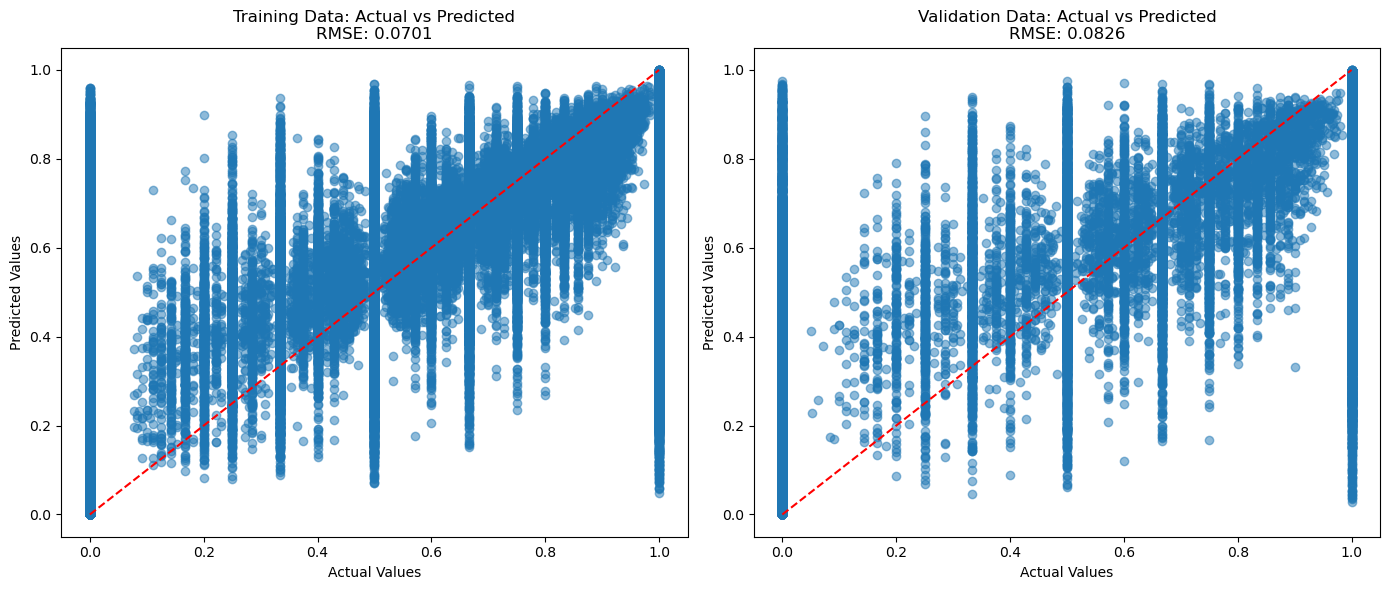

Submission saved → sample_submission_combined_RF.csv
Plot saved → actual_vs_predicted.png


In [54]:
# ------------------------------------------------------------------
# 8. Train/test/validation split for modeling
# ------------------------------------------------------------------
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



# First separate the training data from the final test data
train_df = all_data[all_data["train_label"] == 1].drop(columns=["index"])
test_df = all_data[all_data["train_label"] == 0]



# Now split the training data into train and validation sets (80% train, 20% validation)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Prepare X and y for each set
y_train = train_df["winner_ratio"]
X_train = train_df.drop(columns=["winner_ratio", "train_label"])

y_val = val_df["winner_ratio"]
X_val = val_df.drop(columns=["winner_ratio", "train_label"])

test_idx = test_df["index"]
X_test = test_df.drop(columns=["winner_ratio", "train_label", "index"])

# ------------------------------------------------------------------
# 9. Train Random Forest model directly (no hyperparameter tuning)
# ------------------------------------------------------------------
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import numpy as np

# Create and train a Random Forest model with default parameters
from tqdm.auto import tqdm
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=500,             # more trees = better generalization
    max_depth=20,                 # cap tree depth to avoid overfitting
    min_samples_split=10,        # don't split on tiny sample sets
    min_samples_leaf=4,          # each leaf must have ≥4 points
    max_features='sqrt',         # good default for high-dimensional data
    bootstrap=True,              # enables bagging
    random_state=42,
    n_jobs=-1                     # use all cores
)

pbar = tqdm(total=100, desc="RF trees")
for i in range(1, 101):
    rf.set_params(n_estimators=i)
    rf.fit(X_train, y_train)
    pbar.update(1)
pbar.close()


# Make predictions on train and validation sets
train_pred = rf.predict(X_train)
val_pred = rf.predict(X_val)

# Calculate RMSE for both sets
train_rmse = metrics.mean_squared_error(y_train, train_pred)
val_rmse = metrics.mean_squared_error(y_val, val_pred)

print(f"Training RMSE: {train_rmse:,.4f}")
print(f"Validation RMSE: {val_rmse:,.4f}")

# ------------------------------------------------------------------
# Plot actual vs predicted values for train and validation data
# ------------------------------------------------------------------
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Training data plot
ax1.scatter(y_train, train_pred, alpha=0.5)
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
ax1.set_xlabel('Actual Values')
ax1.set_ylabel('Predicted Values')
ax1.set_title(f'Training Data: Actual vs Predicted\nRMSE: {train_rmse:.4f}')

# Validation data plot
ax2.scatter(y_val, val_pred, alpha=0.5)
ax2.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
ax2.set_xlabel('Actual Values')
ax2.set_ylabel('Predicted Values')
ax2.set_title(f'Validation Data: Actual vs Predicted\nRMSE: {val_rmse:.4f}')

plt.tight_layout()
plt.savefig('actual_vs_predicted.png')
plt.show()

# ------------------------------------------------------------------
# 10. Predict test & save submission
# ------------------------------------------------------------------
test_pred = rf.predict(X_test)
submission = pd.DataFrame({"index": test_idx, "winner_ratio": test_pred})
submission.to_csv("sample_submission_combined_RF.csv", index=False)
print("Submission saved → sample_submission_combined_RF.csv")
print("Plot saved → actual_vs_predicted.png")

In [57]:
import pandas as pd

# Get raw importances
importances = rf.feature_importances_

# Map to feature names and sort
feat_imp = pd.Series(importances, index=X_train.columns)
feat_imp = feat_imp.sort_values(ascending=False)

# View the top 10
print("Top 10 features by importance:")
print(feat_imp.head(10))


NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [58]:
print(type(feat_imp))

NameError: name 'feat_imp' is not defined

In [59]:
top10 = feat_imp.head(10)
top_cols = []
for feature, importance in top10.items():
    top_cols.append(feature)
    print(f"{feature}: {importance}")


NameError: name 'feat_imp' is not defined

In [60]:
top_cols

NameError: name 'top_cols' is not defined

In [61]:

rf = RandomForestRegressor(
    n_estimators=1,
    warm_start=True,   # allow growing more trees without discarding previous ones
    random_state=42,
    n_jobs=-1
)

pbar = tqdm(total=100, desc="RF trees")
for i in range(1, 101):
    rf.set_params(n_estimators=i)
    rf.fit(X_train[top_cols], y_train)
    pbar.update(1)
pbar.close()


# Make predictions on train and validation sets
train_pred = rf.predict(X_train[top_cols])
val_pred = rf.predict(X_val[top_cols])

# Calculate RMSE for both sets
train_rmse = metrics.mean_squared_error(y_train, train_pred)
val_rmse = metrics.mean_squared_error(y_val, val_pred)

print(f"Training RMSE: {train_rmse:,.4f}")
print(f"Validation RMSE: {val_rmse:,.4f}")


RF trees:   0%|          | 0/100 [00:10<?, ?it/s]


NameError: name 'top_cols' is not defined

In [598]:
feat_imp.to_clipboard()

# 2. Base Model with not including specific_sector

In [599]:
all_data = all_data_bkp.copy()

In [600]:
all_data.columns

Index(['contribution_democratic_sum_2010_usd_log',
       'contribution_republican_sum_2010_usd_log',
       'contribution_sum_2010_usd_log',
       'governor_contributions_sum_2010_usd_log',
       'house_and_assembly_contributions_sum_2010_usd_log',
       'senate_contributions_sum_2010_usd_log',
       'us_house_contributions_sum_2010_usd_log',
       'us_senate_contributions_sum_2010_usd_log', 'candidacy_count_log',
       'candidacy_democratic_count_log', 'candidacy_republican_count_log',
       'contribution_count_log', 'contribution_democratic_count_log',
       'contribution_republican_count_log', 'politician_challenger_count_log',
       'politician_count_log', 'politician_democratic_count_log',
       'politician_incumbency_count_log', 'politician_open_pos_count_log',
       'politician_republican_count_log', 'candidacy_democratic_ratio',
       'candidacy_republican_ratio', 'contribution_democratic_count_ratio',
       'contribution_republican_count_ratio', 'governor_contrib

In [601]:
all_data = all_data_bkp.copy()
all_data.drop(["specific_sector"], axis=1, inplace= True)
all_data = pd.get_dummies(
    all_data,
    columns=[
            # "specific_sector", 
             "state", "contributor_type",
             "greedy_modularity", "greedy_modularity_win",
             "louvain_communities", "louvain_communities_win"]
)


KeyError: "['specific_sector'] not found in axis"

In [53]:
# ------------------------------------------------------------------
# 8. Train/test/validation split for modeling
# ------------------------------------------------------------------
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# First separate the training data from the final test data
train_df = all_data[all_data["train_label"] == 1].drop(columns=["index"])
test_df = all_data[all_data["train_label"] == 0]

# Now split the training data into train and validation sets (80% train, 20% validation)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Prepare X and y for each set
y_train = train_df["winner_ratio"]
X_train = train_df.drop(columns=["winner_ratio", "train_label"])

y_val = val_df["winner_ratio"]
X_val = val_df.drop(columns=["winner_ratio", "train_label"])

test_idx = test_df["index"]
X_test = test_df.drop(columns=["winner_ratio", "train_label", "index"])

# ------------------------------------------------------------------
# 9. Train Random Forest model directly (no hyperparameter tuning)
# ------------------------------------------------------------------
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import numpy as np

# Create and train a Random Forest model with default parameters
from tqdm.auto import tqdm
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=1,
    warm_start=True,   # allow growing more trees without discarding previous ones
    random_state=42,
    n_jobs=-1
)

pbar = tqdm(total=100, desc="RF trees")
for i in range(1, 101):
    rf.set_params(n_estimators=i)
    rf.fit(X_train, y_train)
    pbar.update(1)
pbar.close()

# Make predictions on train and validation sets
train_pred = rf.predict(X_train)
val_pred = rf.predict(X_val)

# Calculate RMSE for both sets
train_rmse = metrics.mean_squared_error(y_train, train_pred)
val_rmse = metrics.mean_squared_error(y_val, val_pred)

print(f"Training MSE: {train_rmse:,.4f}")
print(f"Validation MSE: {val_rmse:,.4f}")

# ------------------------------------------------------------------
# Plot actual vs predicted values for train and validation data
# ------------------------------------------------------------------
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Training data plot
ax1.scatter(y_train, train_pred, alpha=0.5)
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
ax1.set_xlabel('Actual Values')
ax1.set_ylabel('Predicted Values')
ax1.set_title(f'Training Data: Actual vs Predicted\nMSE: {train_rmse:.4f}')

# Validation data plot
ax2.scatter(y_val, val_pred, alpha=0.5)
ax2.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
ax2.set_xlabel('Actual Values')
ax2.set_ylabel('Predicted Values')
ax2.set_title(f'Validation Data: Actual vs Predicted\nMSE: {val_rmse:.4f}')

plt.tight_layout()
plt.savefig('actual_vs_predicted.png')
plt.show()

# ------------------------------------------------------------------
# 10. Predict test & save submission
# ------------------------------------------------------------------
test_pred = rf.predict(X_test)
submission = pd.DataFrame({"index": test_idx, "winner_ratio": test_pred})
# submission.to_csv("sample_submission_combined_RF.csv", index=False)
# print("Submission saved → sample_submission_combined_RF.csv")
print("Plot saved → actual_vs_predicted.png")

KeyError: 'train_label'

# 3. Base model with 500 estimators

In [ ]:
# ------------------------------------------------------------------
# 8. Train/test/validation split for modeling
# ------------------------------------------------------------------
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# First separate the training data from the final test data
train_df = all_data[all_data["train_label"] == 1].drop(columns=["index"])
test_df = all_data[all_data["train_label"] == 0]

# Now split the training data into train and validation sets (80% train, 20% validation)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Prepare X and y for each set
y_train = train_df["winner_ratio"]
X_train = train_df.drop(columns=["winner_ratio", "train_label"])

y_val = val_df["winner_ratio"]
X_val = val_df.drop(columns=["winner_ratio", "train_label"])

test_idx = test_df["index"]
X_test = test_df.drop(columns=["winner_ratio", "train_label", "index"])

# ------------------------------------------------------------------
# 9. Train Random Forest model directly (no hyperparameter tuning)
# ------------------------------------------------------------------
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import numpy as np

# Create and train a Random Forest model with default parameters
from tqdm.auto import tqdm
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=1,
    warm_start=True,   # allow growing more trees without discarding previous ones
    random_state=42,
    n_jobs=-1
)

pbar = tqdm(total=500, desc="RF trees")
for i in range(1, 501):
    rf.set_params(n_estimators=i)
    rf.fit(X_train, y_train)
    pbar.update(1)
pbar.close()

# Make predictions on train and validation sets
train_pred = rf.predict(X_train)
val_pred = rf.predict(X_val)

# Calculate RMSE for both sets
train_rmse = metrics.mean_squared_error(y_train, train_pred)
val_rmse = metrics.mean_squared_error(y_val, val_pred)

print(f"Training MSE: {train_rmse:,.4f}")
print(f"Validation MSE: {val_rmse:,.4f}")

import pickle
# Replace 'rf' with your trained model variable name if different
model = rf

# Specify the filename for the pickle file
output_path = "./rf_model_subset.pkl"

# Write the model to disk
with open(output_path, "wb") as f:
    pickle.dump(model, f)

print(f"Model saved to {output_path}")

# ------------------------------------------------------------------
# Plot actual vs predicted values for train and validation data
# ------------------------------------------------------------------
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Training data plot
ax1.scatter(y_train, train_pred, alpha=0.5)
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
ax1.set_xlabel('Actual Values')
ax1.set_ylabel('Predicted Values')
ax1.set_title(f'Training Data: Actual vs Predicted\nMSE: {train_rmse:.4f}')

# Validation data plot
ax2.scatter(y_val, val_pred, alpha=0.5)
ax2.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
ax2.set_xlabel('Actual Values')
ax2.set_ylabel('Predicted Values')
ax2.set_title(f'Validation Data: Actual vs Predicted\nMSE: {val_rmse:.4f}')

plt.tight_layout()
plt.savefig('actual_vs_predicted.png')
plt.show()

# ------------------------------------------------------------------
# 10. Predict test & save submission
# ------------------------------------------------------------------
test_pred = rf.predict(X_test)
submission = pd.DataFrame({"index": test_idx, "winner_ratio": test_pred})
# submission.to_csv("sample_submission_combined_RF.csv", index=False)
# print("Submission saved → sample_submission_combined_RF.csv")
print("Plot saved → actual_vs_predicted.png")

RF trees:  23%|██▎       | 113/500 [02:39<09:15,  1.44s/it]

In [17]:
submission.to_csv("yourVersion_RF_new.csv", index=False)

In [ ]:
import pickle

# Replace 'rf' with your trained model variable name if different
model = rf

# Specify the filename for the pickle file
output_path = "./rf_model_subset.pkl"

# Write the model to disk
with open(output_path, "wb") as f:
    pickle.dump(model, f)

print(f"Model saved to {output_path}")


In [20]:
import pandas as pd

# Get raw importances
importances = rf.feature_importances_

# Map to feature names and sort
feat_imp = pd.Series(importances, index=X_train.columns)
feat_imp = feat_imp.sort_values(ascending=False)

# View the top 10
print("Top 10 features by importance:")
print(feat_imp.head(10))


NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

# 3. Train StackModels

In [19]:
# ───────────────────────────────────────────────────────────────────────────────
# 0 · GLOBAL CONFIG
# ───────────────────────────────────────────────────────────────────────────────
# from sklearn import set_config
# set_config(enable_metadata_routing=True)

# timing helper
from time import perf_counter
t0 = perf_counter()
def tick(msg):
    print(f"[{perf_counter()-t0:6.2f}s] {msg}")

# ───────────────────────────────────────────────────────────────────────────────
# 1 · Imports
# ───────────────────────────────────────────────────────────────────────────────
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import StackingRegressor, RandomForestRegressor
from sklearn.linear_model    import ElasticNetCV, RidgeCV
from sklearn import metrics
from xgboost                 import XGBRegressor
from tqdm.auto               import tqdm                # ← progress bars

# ───────────────────────────────────────────────────────────────────────────────
# 2 · XGB wrapper (bakes in eval_set + verbose)
# ───────────────────────────────────────────────────────────────────────────────
class XGBWithEval(XGBRegressor):
    def __init__(self, *a, eval_set=None, verbose=None, **kw):
        super().__init__(*a, **kw)
        self._eval_set, self._verbose = eval_set, verbose
    def fit(self, X, y, **fit_kw):
        return super().fit(X, y, eval_set=self._eval_set,
                                 verbose=self._verbose, **fit_kw)

# ───────────────────────────────────────────────────────────────────────────────
# 3 · Data split
# ───────────────────────────────────────────────────────────────────────────────
tick("Splitting data")
train_df = all_data[all_data["train_label"] == 1].drop(columns=["index"])
test_df  = all_data[all_data["train_label"] == 0]
train_df, val_df = train_test_split(train_df, test_size=0.20, random_state=42)

y_train, X_train = train_df["winner_ratio"], train_df.drop(columns=["winner_ratio","train_label"])
y_val,   X_val   = val_df["winner_ratio"],   val_df.drop(columns=["winner_ratio","train_label"])
test_idx = test_df["index"]
X_test   = test_df.drop(columns=["winner_ratio","train_label","index"])

# ───────────────────────────────────────────────────────────────────────────────
# 4 · Base learners
# ───────────────────────────────────────────────────────────────────────────────
tick("Configuring base learners")
xgb = XGBWithEval(
    n_estimators=800, learning_rate=0.05, max_depth=7, subsample=0.8,
    colsample_bytree=0.8, objective="reg:squarederror", random_state=42,
    n_jobs=-1, verbosity=1, eval_set=[(X_train, y_train),(X_val, y_val)],
    verbose=100,
)

rf   = RandomForestRegressor(n_estimators=600, random_state=42, n_jobs=-1)
enet = ElasticNetCV(l1_ratio=[0.1,0.5,0.9,1.0],
                    alphas=np.logspace(-4,1,30), cv=5, n_jobs=-1,
                    random_state=42)
meta = RidgeCV(alphas=np.logspace(-3,3,13))

# ───────────────────────────────────────────────────────────────────────────────
# 5 · StackingRegressor with tqdm wrapper
# ───────────────────────────────────────────────────────────────────────────────
class TQDMStack(StackingRegressor):
    """StackingRegressor that wraps _fit_single_estimator with tqdm."""
    def _fit_single_estimator(self, estimator, X, y, sample_weight,
                              message_clsname, message):
        with tqdm(total=1, desc=message_clsname, leave=False) as pbar:
            result = super()._fit_single_estimator(
                estimator, X, y, sample_weight, message_clsname, message
            )
            pbar.update()
        return result

stack = TQDMStack(
    estimators=[("xgb", xgb), ("rf", rf), ("enet", enet)],
    final_estimator=meta, passthrough=True, n_jobs=-1, verbose=2
)

# ───────────────────────────────────────────────────────────────────────────────
# 6 · Fit
# ───────────────────────────────────────────────────────────────────────────────
tick("Fitting StackingRegressor…")
stack.fit(X_train, y_train)
tick("Stack fitting complete")

# ───────────────────────────────────────────────────────────────────────────────
# 7 · Evaluate + plot
# ───────────────────────────────────────────────────────────────────────────────
tick("Scoring & plotting")
train_pred = stack.predict(tqdm(X_train, desc="Predict train", leave=False))
val_pred   = stack.predict(tqdm(X_val,   desc="Predict val",   leave=False))

train_rmse = metrics.mean_squared_error(y_train, train_pred, squared=False)
val_rmse   = metrics.mean_squared_error(y_val,   val_pred,   squared=False)

print(f"Training RMSE:   {train_rmse:,.4f}")
print(f"Validation RMSE: {val_rmse:,.4f}")

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(14,6))
ax1.scatter(y_train, train_pred, alpha=0.5)
ax1.plot([y_train.min(),y_train.max()],[y_train.min(),y_train.max()],'r--')
ax1.set(title=f"Train: RMSE {train_rmse:.4f}", xlabel="Actual", ylabel="Predicted")
ax2.scatter(y_val, val_pred, alpha=0.5)
ax2.plot([y_val.min(),y_val.max()],[y_val.min(),y_val.max()],'r--')
ax2.set(title=f"Val: RMSE {val_rmse:.4f}", xlabel="Actual", ylabel="Predicted")
plt.tight_layout(); plt.savefig("actual_vs_predicted.png"); plt.show()

# ───────────────────────────────────────────────────────────────────────────────
# 8 · Predict test
# ───────────────────────────────────────────────────────────────────────────────
tick("Predicting test set")
test_pred = stack.predict(tqdm(X_test, desc="Predict test", leave=False))
submission = pd.DataFrame({"index": test_idx, "winner_ratio": test_pred})
# submission.to_csv("sample_submission_stacked.csv", index=False)
tick("Done ▶  Plot saved → actual_vs_predicted.png")


[  0.04s] Splitting data
[  0.17s] Configuring base learners
[  0.27s] Fitting StackingRegressor…


RuntimeError: scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class '__main__.XGBWithEval'> with constructor (self, *a, eval_set=None, verbose=None, **kw) doesn't  follow this convention.

In [5]:
# ------------------------------------------------------------------
# 8. Train/test/validation split for modeling
# ------------------------------------------------------------------
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# First separate the training data from the final test data
train_df = all_data[all_data["train_label"] == 1].drop(columns=["index"])
test_df = all_data[all_data["train_label"] == 0]

# Now split the training data into train and validation sets (80% train, 20% validation)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Prepare X and y for each set
y_train = train_df["winner_ratio"]
X_train = train_df.drop(columns=["winner_ratio", "train_label"])

y_val = val_df["winner_ratio"]
X_val = val_df.drop(columns=["winner_ratio", "train_label"])

test_idx = test_df["index"]
X_test = test_df.drop(columns=["winner_ratio", "train_label", "index"])

# ------------------------------------------------------------------
# 9. Train Random Forest model directly (no hyperparameter tuning)
# ------------------------------------------------------------------
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import numpy as np

# Create and train a Random Forest model with default parameters
from tqdm.auto import tqdm
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=1,
    warm_start=True,   # allow growing more trees without discarding previous ones
    random_state=42,
    n_jobs=-1
)

pbar = tqdm(total=500, desc="RF trees")
for i in range(1, 501):
    rf.set_params(n_estimators=i)
    rf.fit(X_train, y_train)
    pbar.update(1)
pbar.close()


# Make predictions on train and validation sets
train_pred = rf.predict(X_train)
val_pred = rf.predict(X_val)

# Calculate RMSE for both sets
train_rmse = metrics.mean_squared_error(y_train, train_pred)
val_rmse = metrics.mean_squared_error(y_val, val_pred)

print(f"Training RMSE: {train_rmse:,.4f}")
print(f"Validation RMSE: {val_rmse:,.4f}")

# ------------------------------------------------------------------
# Plot actual vs predicted values for train and validation data
# ------------------------------------------------------------------
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Training data plot
ax1.scatter(y_train, train_pred, alpha=0.5)
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
ax1.set_xlabel('Actual Values')
ax1.set_ylabel('Predicted Values')
ax1.set_title(f'Training Data: Actual vs Predicted\nRMSE: {train_rmse:.4f}')

# Validation data plot
ax2.scatter(y_val, val_pred, alpha=0.5)
ax2.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
ax2.set_xlabel('Actual Values')
ax2.set_ylabel('Predicted Values')
ax2.set_title(f'Validation Data: Actual vs Predicted\nRMSE: {val_rmse:.4f}')

plt.tight_layout()
plt.savefig('actual_vs_predicted.png')
plt.show()

# ------------------------------------------------------------------
# 10. Predict test & save submission
# ------------------------------------------------------------------
test_pred = rf.predict(X_test)
submission = pd.DataFrame({"index": test_idx, "winner_ratio": test_pred})
submission.to_csv("sample_submission_combined_RF.csv", index=False)
# print("Submission saved → sample_submission_combined_RF.csv")
print("Plot saved → actual_vs_predicted.png")

In [6]:
def coerce_numeric(df):
    obj_cols = df.select_dtypes(include="object").columns
    print("obj_cols :", obj_cols)
    for c in obj_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df
all_data = coerce_numeric(all_data).fillna(0)



obj_cols : Index(['governor_contribution_ratio', 'senate_contribution_ratio',
       'us_senate_contribution_ratio'],
      dtype='object')


In [ ]:
# ------------------------------------------------------------------
# 8. Train/test/validation split for modeling
# ------------------------------------------------------------------
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# First separate the training data from the final test data
train_df = all_data[all_data["train_label"] == 1].drop(columns=["index"])
test_df = all_data[all_data["train_label"] == 0]

# Now split the training data into train and validation sets (80% train, 20% validation)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Prepare X and y for each set
y_train = train_df["winner_ratio"]
X_train = train_df.drop(columns=["winner_ratio", "train_label"])

y_val = val_df["winner_ratio"]
X_val = val_df.drop(columns=["winner_ratio", "train_label"])

test_idx = test_df["index"]
X_test = test_df.drop(columns=["winner_ratio", "train_label", "index"])

# ------------------------------------------------------------------
# 9. Train a StackingRegressor (XGB + RF + ElasticNet)
# ------------------------------------------------------------------
from sklearn.ensemble import (
    StackingRegressor,
    RandomForestRegressor
)
from sklearn.linear_model   import ElasticNetCV, RidgeCV
from xgboost                import XGBRegressor
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm   # still useful for XGB progress

# ---- Base (level-0) learners -------------------------------------------------
xgb = XGBRegressor(
    n_estimators        = 800,
    learning_rate       = 0.05,
    max_depth           = 7,
    subsample           = 0.8,
    colsample_bytree    = 0.8,
    objective           = "reg:squarederror",
    random_state        = 42,
    n_jobs              = -1
)

rf = RandomForestRegressor(
    n_estimators        = 600,
    max_depth           = None,
    min_samples_split   = 2,
    min_samples_leaf    = 1,
    bootstrap           = True,
    random_state        = 42,
    n_jobs              = -1
)

enet = ElasticNetCV(
    l1_ratio            = [0.1, 0.5, 0.9, 1.0],
    alphas              = np.logspace(-4, 1, 30),
    cv                  = 5,
    n_jobs              = -1,
    random_state        = 42
)

# ---- Meta (level-1) learner --------------------------------------------------
meta = RidgeCV(alphas=np.logspace(-3, 3, 13))

# ---- Assemble the stack ------------------------------------------------------
stack = StackingRegressor(
    estimators=[
        ("xgb",  xgb),
        ("rf",   rf),
        ("enet", enet),
    ],
    final_estimator     = meta,
    passthrough         = True,   # feed original features to meta-learner
    n_jobs              = -1
)

# ---- Fit ---------------------------------------------------------------------
print("Fitting stacking model …")
stack.fit(X_train, y_train)

# ------------------------------------------------------------------
# 10. Evaluate + plot
# ------------------------------------------------------------------
train_pred = stack.predict(X_train)
val_pred   = stack.predict(X_val)

train_rmse = metrics.mean_squared_error(y_train, train_pred, squared=False)  # RMSE
val_rmse   = metrics.mean_squared_error(y_val,   val_pred,   squared=False)

print(f"Training RMSE:   {train_rmse:,.4f}")
print(f"Validation RMSE: {val_rmse:,.4f}")

# Plot actual vs predicted
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.scatter(y_train, train_pred, alpha=0.5)
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
ax1.set_xlabel('Actual Values')
ax1.set_ylabel('Predicted Values')
ax1.set_title(f'Training Data: Actual vs Predicted\nRMSE: {train_rmse:.4f}')

ax2.scatter(y_val, val_pred, alpha=0.5)
ax2.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
ax2.set_xlabel('Actual Values')
ax2.set_ylabel('Predicted Values')
ax2.set_title(f'Validation Data: Actual vs Predicted\nRMSE: {val_rmse:.4f}')

plt.tight_layout()
plt.savefig('actual_vs_predicted.png')
plt.show()

# ------------------------------------------------------------------
# 11. Predict test & save submission
# ------------------------------------------------------------------
test_pred   = stack.predict(X_test)
submission  = pd.DataFrame({"index": test_idx, "winner_ratio": test_pred})
# submission.to_csv("sample_submission_stacked.csv", index=False)
print("Plot saved → actual_vs_predicted.png")

Fitting stacking model …


/opt/anaconda3/envs/env3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8734.53730790802, tolerance: 1.8683616578445938
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/env3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8445.515330376587, tolerance: 1.8683616578445938
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/env3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8047.169688418726, tolerance: 1.8683616578445938
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/env3.11/lib/python3.11/site-pa

In [3]:
hgfhfg

NameError: name 'hgfhfg' is not defined

/opt/anaconda3/envs/tf_macos/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
RF trees: 100%|██████████| 100/100 [11:43<00:00,  7.03s/it]


Training RMSE: 0.1072
Validation RMSE: 0.2847


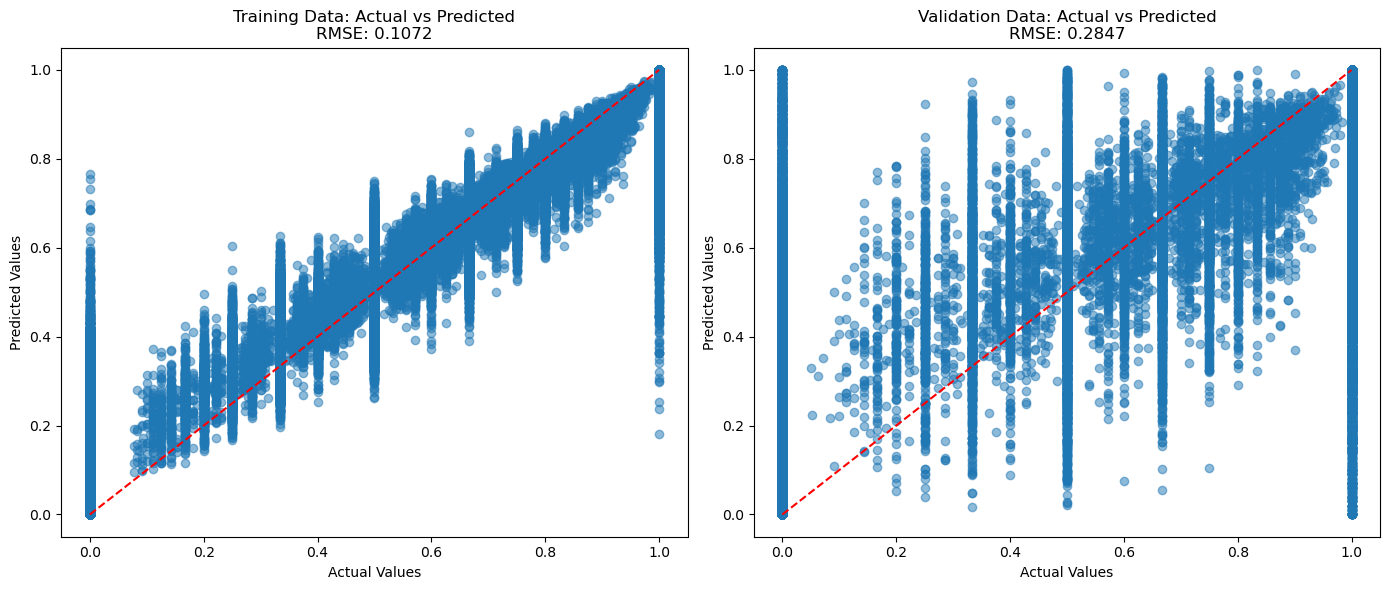

Submission saved → sample_submission_combined_RF.csv
Plot saved → actual_vs_predicted.png


In [8]:
# ------------------------------------------------------------------
# 8. Train/test/validation split for modeling
# ------------------------------------------------------------------
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# First separate the training data from the final test data
train_df = all_data[all_data["train_label"] == 1].drop(columns=["index"])
test_df = all_data[all_data["train_label"] == 0]

# Now split the training data into train and validation sets (80% train, 20% validation)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Prepare X and y for each set
y_train = train_df["winner_ratio"]
X_train = train_df.drop(columns=["winner_ratio", "train_label"])

y_val = val_df["winner_ratio"]
X_val = val_df.drop(columns=["winner_ratio", "train_label"])

test_idx = test_df["index"]
X_test = test_df.drop(columns=["winner_ratio", "train_label", "index"])

# ------------------------------------------------------------------
# 9. Train Random Forest model directly (no hyperparameter tuning)
# ------------------------------------------------------------------
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import numpy as np

# Create and train a Random Forest model with default parameters
from tqdm.auto import tqdm
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=1,
    warm_start=True,   # allow growing more trees without discarding previous ones
    random_state=42,
    n_jobs=-1
)

pbar = tqdm(total=100, desc="RF trees")
for i in range(1, 101):
    rf.set_params(n_estimators=i)
    rf.fit(X_train, y_train)
    pbar.update(1)
pbar.close()


# Make predictions on train and validation sets
train_pred = rf.predict(X_train)
val_pred = rf.predict(X_val)

# Calculate RMSE for both sets
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, train_pred))
val_rmse = np.sqrt(metrics.mean_squared_error(y_val, val_pred))

print(f"Training RMSE: {train_rmse:,.4f}")
print(f"Validation RMSE: {val_rmse:,.4f}")

# ------------------------------------------------------------------
# Plot actual vs predicted values for train and validation data
# ------------------------------------------------------------------
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Training data plot
ax1.scatter(y_train, train_pred, alpha=0.5)
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
ax1.set_xlabel('Actual Values')
ax1.set_ylabel('Predicted Values')
ax1.set_title(f'Training Data: Actual vs Predicted\nRMSE: {train_rmse:.4f}')

# Validation data plot
ax2.scatter(y_val, val_pred, alpha=0.5)
ax2.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
ax2.set_xlabel('Actual Values')
ax2.set_ylabel('Predicted Values')
ax2.set_title(f'Validation Data: Actual vs Predicted\nRMSE: {val_rmse:.4f}')

plt.tight_layout()
plt.savefig('actual_vs_predicted.png')
plt.show()

# ------------------------------------------------------------------
# 10. Predict test & save submission
# ------------------------------------------------------------------
test_pred = rf.predict(X_test)
submission = pd.DataFrame({"index": test_idx, "winner_ratio": test_pred})
submission.to_csv("sample_submission_combined_RF.csv", index=False)
print("Submission saved → sample_submission_combined_RF.csv")
print("Plot saved → actual_vs_predicted.png")

In [10]:
all_data.columns.to_list()

['general_sector',
 'city',
 'zip_code',
 'winner_ratio',
 'candidacy_count',
 'candidacy_democratic_count',
 'candidacy_republican_count',
 'contribution_count',
 'contribution_democratic_count',
 'contribution_republican_count',
 'politician_challenger_count',
 'politician_count',
 'politician_democratic_count',
 'politician_incumbency_count',
 'politician_open_pos_count',
 'politician_republican_count',
 'contribution_democratic_sum_2010_usd',
 'contribution_republican_sum_2010_usd',
 'contribution_sum_2010_usd',
 'governor_contributions_sum_2010_usd',
 'house_and_assembly_contributions_sum_2010_usd',
 'senate_contributions_sum_2010_usd',
 'us_house_contributions_sum_2010_usd',
 'us_senate_contributions_sum_2010_usd',
 'candidacy_democratic_ratio',
 'candidacy_republican_ratio',
 'contribution_democratic_count_ratio',
 'contribution_republican_count_ratio',
 'governor_contribution_ratio',
 'house_and_assembly_contribution_ratio',
 'politician_challenger_ratio',
 'politician_democrat

In [11]:
# Step 1: filter out categorical or one-hot columns
cat_prefixes = [
    'specific_sector_', 'state_', 'contributor_type_',
    'greedy_modularity_', 'greedy_modularity_win_',
    'louvain_communities_', 'louvain_communities_win_'
]
original_cats = ['general_sector', 'city', 'zip_code']

# Step 2: define a function to identify non-categorical, numeric vars
def get_numeric_columns(df, target='winner_ratio'):
    return [
        col for col in df.columns
        if col not in original_cats
        and not any(col.startswith(prefix) for prefix in cat_prefixes)
        and df[col].dtype in [np.float64, np.int64]
        and col != 'train_label'
        and col != 'index'
        and col != target  # we'll correlate against it
    ]

# Step 3: get numeric columns
numeric_vars = get_numeric_columns(all_data)

# Step 4: compute correlation with target variable
correlations = all_data[numeric_vars + ['winner_ratio']].corr()['winner_ratio'].sort_values(ascending=False)

# Optional: display top and bottom correlated variables
print("🔼 Top positively correlated variables with winner_ratio:")
print(correlations.head(10))

print("\n🔽 Top negatively correlated variables with winner_ratio:")
print(correlations.tail(10))

# Or store them to inspect
correlations_df = correlations.drop(labels='winner_ratio').reset_index()
correlations_df.columns = ['variable', 'correlation_with_winner_ratio']


🔼 Top positively correlated variables with winner_ratio:
winner_ratio                             1.000000
politician_incumbency_ratio              0.291710
mean_deg_state_by_type                   0.063819
mean_deg_federal_by_type                 0.063674
politician_incumbency_count              0.063291
house_and_assembly_contribution_ratio    0.048330
politician_republican_count              0.030501
politician_count                         0.029948
candidacy_count                          0.028717
candidacy_republican_count               0.028319
Name: winner_ratio, dtype: float64

🔽 Top negatively correlated variables with winner_ratio:
mean_deg_state_by_state       -0.013287
mean_deg_federal_by_state     -0.015806
d_weight_all                  -0.025690
d_weight_win                  -0.026470
politician_challenger_count   -0.042969
politician_open_pos_ratio     -0.147645
politician_challenger_ratio   -0.191890
mean_deg_federal_by_zip             NaN
mean_deg_state_by_stz         

In [ ]:
# ------------------------------------------------------------------
# 8. Train/test/validation split for modeling
# ------------------------------------------------------------------
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# First separate the training data from the final test data
train_df = all_data[all_data["train_label"] == 1].drop(columns=["index"])
test_df = all_data[all_data["train_label"] == 0]

# Now split the training data into train and validation sets (80% train, 20% validation)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Prepare X and y for each set
y_train = train_df["winner_ratio"]
X_train = train_df.drop(columns=["winner_ratio", "train_label"])

y_val = val_df["winner_ratio"]
X_val = val_df.drop(columns=["winner_ratio", "train_label"])

test_idx = test_df["index"]
X_test = test_df.drop(columns=["winner_ratio", "train_label", "index"])

# ------------------------------------------------------------------
# 9. Train Random Forest model directly (no hyperparameter tuning)
# ------------------------------------------------------------------
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import numpy as np

# Create and train a Random Forest model with default parameters
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions on train and validation sets
train_pred = rf.predict(X_train)
val_pred = rf.predict(X_val)

# Calculate RMSE for both sets
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, train_pred))
val_rmse = np.sqrt(metrics.mean_squared_error(y_val, val_pred))

print(f"Training RMSE: {train_rmse:,.4f}")
print(f"Validation RMSE: {val_rmse:,.4f}")

# ------------------------------------------------------------------
# Plot actual vs predicted values for train and validation data
# ------------------------------------------------------------------
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Training data plot
ax1.scatter(y_train, train_pred, alpha=0.5)
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
ax1.set_xlabel('Actual Values')
ax1.set_ylabel('Predicted Values')
ax1.set_title(f'Training Data: Actual vs Predicted\nRMSE: {train_rmse:.4f}')

# Validation data plot
ax2.scatter(y_val, val_pred, alpha=0.5)
ax2.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
ax2.set_xlabel('Actual Values')
ax2.set_ylabel('Predicted Values')
ax2.set_title(f'Validation Data: Actual vs Predicted\nRMSE: {val_rmse:.4f}')

plt.tight_layout()
plt.savefig('actual_vs_predicted.png')
plt.show()

# ------------------------------------------------------------------
# 10. Predict test & save submission
# ------------------------------------------------------------------
test_pred = rf.predict(X_test)
submission = pd.DataFrame({"index": test_idx, "winner_ratio": test_pred})
submission.to_csv("sample_submission_combined_RF.csv", index=False)
print("Submission saved → sample_submission_combined_RF.csv")
print("Plot saved → actual_vs_predicted.png")

In [ ]:
ratan

In [ ]:
# ------------------------------------------------------------------
# 8. Train/test split for modeling
# ------------------------------------------------------------------
train_df = all_data[all_data["train_label"] == 1].drop(columns=["index"])
test_df  = all_data[all_data["train_label"] == 0]

y_train = train_df["winner_ratio"]
X_train = train_df.drop(columns=["winner_ratio", "train_label"])
test_idx = test_df["index"]
X_test  = test_df.drop(columns=["winner_ratio", "train_label", "index"])

# ------------------------------------------------------------------
# 9. Random Forest + RandomizedSearchCV
# ------------------------------------------------------------------
param_dists = {
    "n_estimators": range(1, 50, 5),
    "max_depth": range(1, 30, 5),
    "min_samples_split": [2, 3, 4],
    "min_samples_leaf": [1, 2, 3, 4, 5],
}

rf = RandomForestRegressor(random_state=42)
rf_cv = RandomizedSearchCV(
    rf, param_dists, n_iter=300, cv=3,
    scoring="neg_mean_squared_error", n_jobs=-1, verbose=1
)
rf_cv.fit(X_train, y_train)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, rf_cv.predict(X_train)))
print(f"Training RMSE: {train_rmse:,.4f}")

# ------------------------------------------------------------------
# 10. Predict test & save submission
# ------------------------------------------------------------------
test_pred = rf_cv.predict(X_test)
submission = pd.DataFrame({"index": test_idx, "winner_ratio": test_pred})
submission.to_csv("sample_submission_combined_RF.csv", index=False)
print("Submission saved → sample_submission_combined_RF.csv")
